# 头文件导入

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
import re
import time
import gc
import math
import pickle
import os

In [3]:
# 构造Overview类,用于对数据进行整体观测
class Overview:
    """
    对数据的总体观测,包含以下的类成员和函数:
    self.reduce_memory_usage(df): 压缩df表格占用的内存大小
    self.frame_view(df): 查看df的大致属性
    self.frame_type_view(df): 查看df的列的属性
    self.missing_values_table(df): 查看df的列的缺失值情况
    """

    def __init__(self):
        pass

    @staticmethod
    def reduce_memory_usage(df):
        start_mem = df.memory_usage().sum() / 1024 ** 2
        print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
        for col in df.columns:
            col_type = df[col].dtype
            if col_type != object:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
        end_mem = df.memory_usage().sum() / 1024 ** 2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(
            100 * (start_mem - end_mem) / start_mem))
        return df

    @staticmethod
    def frame_view(df):
        print('\033[0;31;40m data shape is \033[0m', df.shape)
        print(df.describe())
        print(df.info())

    @staticmethod
    def frame_type_view(df):
        print("\033[0;31;40m dataframe datatype: \033[0m")
        print(df.dtypes.value_counts())
        print("\033[0;31;40m the num of every dataframe datatype: \033[0m")
        print(df.select_dtypes('object').apply(pd.Series.nunique, axis=0))
        print("\033[0;31;40m Features: \033[0m")
        print(df.columns.values)

    @staticmethod
    def missing_values_table(df):
        mis_val = df.isnull().sum()  # 总缺失值
        mis_val_percent = 100 * df.isnull().sum() / len(df)  # 计算缺失值的百分比
        mis_val_table = pd.concat(
            [mis_val, mis_val_percent], axis=1)  # 显示结果的表格
        mis_val_table_ren_columns = mis_val_table.rename(
            columns={0: 'Missing Values', 1: '% of Total Values'})  # 重命名列
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
            '% of Total Values', ascending=False).round(1)  # 按下降百分比对表进行排序
        print("\033[0;31;40m Your selected dataframe has \033[0m" + str(
            df.shape[1]) + "\033[0;31;40m columns. \033[0m\n"
                           "\033[0;31;40m There are \033[0m" + str(mis_val_table_ren_columns.shape[0]) +
              "\033[0;31;40m columns that have missing values. \033[0m")  # 显示部分信息
        print(mis_val_table_ren_columns)  # 打印缺少的信息值


In [4]:
# 构造Paint类,用于绘制图像
class Paint:
    """
    对图片的绘制, 包含以下函数:
    univariate_barplots(data, col1, col2, top, printCount, printUnique, fill): 
        绘制条形图,查看col1的分类情况以及每个类中col2的分类情况
        若设置printCount=True,则打印data[col1].value_counts()
        若设置printUnique=True,则打印data[col1].unique()
        若设置fill=True,则会对缺失的数据进行填充
    distplot(data, col, fill): 
        绘制对比折线图
        若设置fill=True,则会对缺失的数据进行填充
    """

    def __init__(self):
        pass

    @staticmethod
    def univariate_barplots(data, col1, col2="TARGET", top=False, printCount=False, printUnique=False, fill=False):
        if printCount is True:
            print(data[col1].value_counts())
        if printUnique is True:
            print(data[col1].unique())
        if fill is True:
            data[col1].fillna('Data_Not_Available', inplace=True)
        temp = pd.DataFrame(data.groupby(col1)[col2].agg(
            lambda x: x.eq(1).sum())).reset_index()
        temp['total'] = pd.DataFrame(data.groupby(
            col1)[col2].agg(total='count')).reset_index()['total']
        temp['Avg'] = pd.DataFrame(data.groupby(
            col1)[col2].agg(Avg='mean')).reset_index()['Avg']
        temp.sort_values(by=['total'], inplace=True, ascending=False)
        if top is True:
            temp = temp[0:top]
        ind = np.arange(temp.shape[0])
        if len(temp[col1].unique()) < 5:
            plt.figure(figsize=(5, 5))
        elif len(temp[col1].unique()) > 5 & len(temp[col1].unique()) < 10:
            plt.figure(figsize=(7, 7))
        else:
            plt.figure(figsize=(15, 15))
        p1 = plt.bar(ind, temp["total"].values)
        p2 = plt.bar(ind, temp[col2].values)
        plt.ylabel('Loans')
        plt.title('Number of loans aproved vs rejected')
        plt.xticks(ticks=ind, rotation=90, labels=list(temp[col1].values))
        plt.legend((p1[0], p2[0]), ('capable', 'not capable'))
        plt.show()
        print(temp.head(5))
        print("=" * 50)
        print(temp.tail(5))

    @staticmethod
    def distplot(data, col, fill=False):
        if fill is True:
            data['CNT_FAM_MEMBERS'].fillna(
                data[col].value_counts().idxmax(), inplace=True)
        capable_loan_annuity = data[data['TARGET']
                                       == 0][col].values
        not_capable_loan_annuity = data[data['TARGET']
                                           == 1][col].values
        plt.figure(figsize=(10, 3))
        sns.distplot(capable_loan_annuity, hist=False,
                     label="Capable of Repayment", color='green')
        sns.distplot(not_capable_loan_annuity, hist=False,
                     label="Not Capable of Repayment", color='red')
        plt.legend()
        plt.show()

In [5]:
# 创建上述2个类的实例对象
overview = Overview()
paint = Paint()

In [6]:
# 导入训练集
train_data = overview.reduce_memory_usage(pd.read_csv("F:/data/application_train.csv")) # 文件地址根据自己的情况进行修改
print('Number of data points : ', train_data.shape[0])
print('Number of features : ', train_data.shape[1])
overview.frame_view(train_data)
overview.frame_type_view(train_data)

# 导入测试集
test_data = overview.reduce_memory_usage(pd.read_csv("F:/data/application_test.csv")) # 文件地址根据自己的情况进行修改
print('Number of data points : ', test_data.shape[0])
print('Number of features : ', test_data.shape[1])
overview.frame_view(test_data)
overview.frame_type_view(test_data)

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Number of data points :  307511
Number of features :  122
 data shape is  (307511, 122)
          SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687391e+05   
std    102790.175348       0.272419       0.722121      2.371759e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.988308e+05   27110.958984     5.379796e+0

In [7]:
# 首先观测一下可以借款和无法借款的人数比例
print(train_data['TARGET'].value_counts())

0    282686
1     24825
Name: TARGET, dtype: int64


Number of customers who will not repay the loan on time:  24825 , ( 8.072881945686495 %)
Number of customers who will repay the loan on time:  282686 , ( 91.92711805431351 %)


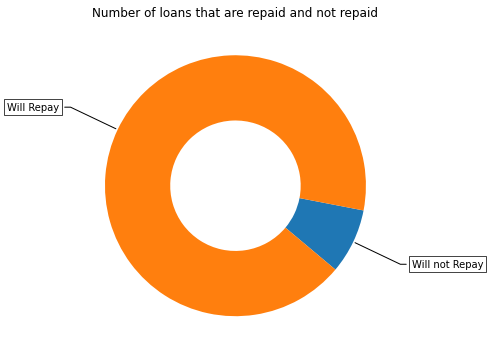

In [8]:
# 从上述结果可以发现,该数据集极度不均衡,通过可视化进一步加深判断的准确性
y_value_counts = train_data['TARGET'].value_counts()
print("Number of customers who will not repay the loan on time: ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of customers who will repay the loan on time: ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Will not Repay", "Will Repay"]
data = [y_value_counts[1], y_value_counts[0]]
wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5),startangle=-40)
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)
ax.set_title("Number of loans that are repaid and not repaid")
plt.show()

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64


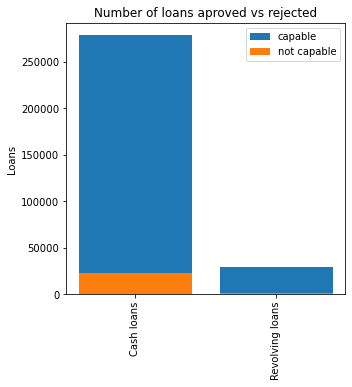

  NAME_CONTRACT_TYPE  TARGET   total       Avg
0         Cash loans   23221  278232  0.083459
1    Revolving loans    1604   29279  0.054783
  NAME_CONTRACT_TYPE  TARGET   total       Avg
0         Cash loans   23221  278232  0.083459
1    Revolving loans    1604   29279  0.054783


In [9]:
# 观测NAME_CONTRACT_TYPE特征,表示不同贷款形式的人数情况以及对应的能否准时偿还的人数
# 可以发现,大多数人以现金贷款的形式贷款,而不是信用卡等方式贷款
paint.univariate_barplots(data = train_data, col1='NAME_CONTRACT_TYPE',printCount=True)

**这里有趣的一点是**
与男性相比,女性贷款的人数要多得多：女性总共获得了202K多笔贷款,而男性只获得了105K多笔\
然而,与此同时,与女性相比,男性偿还贷款的能力略强.10%的男性能够偿还贷款,而女性只有7%能偿还贷款\
有4个条目的性别=“XNA”.由于这并没有为我们提供太多信息,我们可以稍后删除这些条目

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64


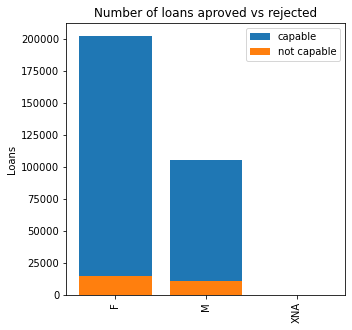

  CODE_GENDER  TARGET   total       Avg
0           F   14170  202448  0.069993
1           M   10655  105059  0.101419
2         XNA       0       4  0.000000
  CODE_GENDER  TARGET   total       Avg
0           F   14170  202448  0.069993
1           M   10655  105059  0.101419
2         XNA       0       4  0.000000


In [10]:
paint.univariate_barplots(data = train_data, col1='CODE_GENDER',printCount=True)

N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64


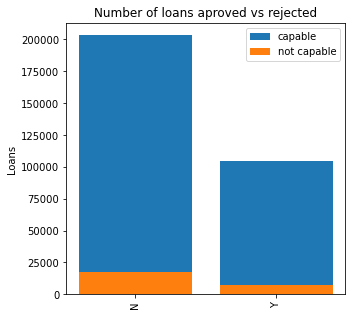

  FLAG_OWN_CAR  TARGET   total       Avg
0            N   17249  202924  0.085002
1            Y    7576  104587  0.072437
  FLAG_OWN_CAR  TARGET   total       Avg
0            N   17249  202924  0.085002
1            Y    7576  104587  0.072437


In [11]:
# 从数据可以看出,大多数申请贷款的人都没有汽车
# 然而,根据这些信息,客户的贷款偿还状况没有太大差异(分别为8.5%和7.2%)
# 我们可以得出这样的结论：这个自变量的影响较小
paint.univariate_barplots(data = train_data, col1='FLAG_OWN_CAR',printCount=True)

Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64


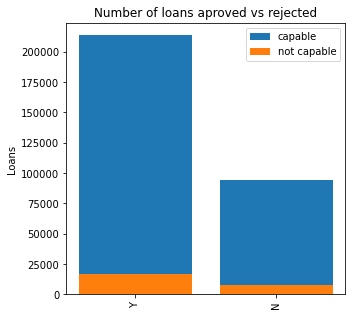

  FLAG_OWN_REALTY  TARGET   total       Avg
1               Y   16983  213312  0.079616
0               N    7842   94199  0.083249
  FLAG_OWN_REALTY  TARGET   total       Avg
1               Y   16983  213312  0.079616
0               N    7842   94199  0.083249


In [12]:
# 可以发现,大多数申请贷款的人都有一套公寓/房子,这有点令人惊讶
# 然而,同样,基于这些信息,客户的贷款偿还状态没有太大差异(分别为7.9%和8.3%)
# 我们可以得出这样的结论：这个特征的影响作用也较小
paint.univariate_barplots(data = train_data, col1='FLAG_OWN_REALTY',printCount=True)

0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
14         3
8          2
9          2
12         2
10         2
19         2
11         1
Name: CNT_CHILDREN, dtype: int64


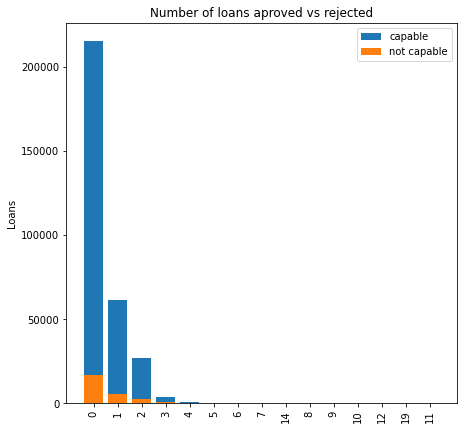

   CNT_CHILDREN  TARGET   total       Avg
0             0   16609  215371  0.077118
1             1    5454   61119  0.089236
2             2    2333   26749  0.087218
3             3     358    3717  0.096314
4             4      55     429  0.128205
    CNT_CHILDREN  TARGET  total  Avg
9              9       2      2  1.0
10            10       0      2  0.0
12            12       0      2  0.0
14            19       0      2  0.0
11            11       1      1  1.0


In [13]:
# 没有孩子的人进行贷款申请的人数是最高的
# 然而,同样,基于这些信息,客户的贷款偿还状态没有太大差异
# 我们可以得出这样的结论：这个特征的影响作用也较小
paint.univariate_barplots(data = train_data, col1='CNT_CHILDREN',printCount=True)

In [14]:
# 计算每个人的平均收入并按照SK_ID_CURR进行排序
income_data = train_data.groupby('SK_ID_CURR').agg({'AMT_INCOME_TOTAL':'mean'}).reset_index()
print(income_data)

        SK_ID_CURR  AMT_INCOME_TOTAL
0           100002          202500.0
1           100003          270000.0
2           100004           67500.0
3           100006          135000.0
4           100007          121500.0
...            ...               ...
307506      456251          157500.0
307507      456252           72000.0
307508      456253          153000.0
307509      456254          171000.0
307510      456255          157500.0

[307511 rows x 2 columns]


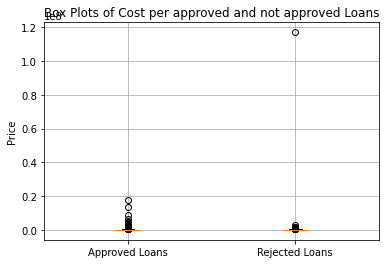

In [15]:
# 将train_data和income_data按照SK_ID_CURR列进行左连接(left join).这将基于SK_ID_CURR将两个数据集合并在一起,使得每个样本都包含其对应的平均收入数据.
income_data_final = pd.merge(train_data, income_data, on='SK_ID_CURR', how='left')
# 从合并后的数据中选取目标(TARGET)为0的样本,并提取这些样本的原始收入(AMT_INCOME_TOTAL_x)值.这将得到一个数组
approved_income = income_data_final[income_data_final['TARGET']==0]['AMT_INCOME_TOTAL_x'].values
# 从合并后的数据中选取目标(TARGET)为1的样本,并提取这些样本的原始收入(AMT_INCOME_TOTAL_x)值.这将得到一个数组
rejected_income = income_data_final[income_data_final['TARGET']==1]['AMT_INCOME_TOTAL_x'].values
# 使用Matplotlib库绘制箱线图,将approved_income和rejected_income作为数据输入.这将生成两个箱线图,分别表示被批准和被拒绝的贷款的收入分布情况.
plt.boxplot([approved_income, rejected_income])
plt.title('Box Plots of Cost per approved and not approved Loans')
plt.xticks([1,2],('Approved Loans','Rejected Loans'))
plt.ylabel('Price')
plt.grid()
plt.show()

In [16]:
x = PrettyTable() # 创建一个新的PrettyTable对象,用于存储表格数据.
# 设置表格的列名,分别为"Percentile"、"Approved Loans"和"Not Approved Loans".
x.field_names = ["Percentile", "Approved Loans", "Not Approved Loans"]
# 通过循环,以5%的间隔遍历从0到100的百分位数.
for i in range(0,101,5): 
    # 在表格中添加一行数据.该行数据由三列组成,分别是当前百分位数(i)、
    # 被批准贷款的收入百分位数(approved_income中对应百分位数的值)和
    # 被拒绝贷款的收入百分位数(rejected_income中对应百分位数的值).
    # 使用np.round函数对收入百分位数进行四舍五入并保留三位小数.
    x.add_row([i,np.round(np.percentile(approved_income,i), 3),\
               np.round(np.percentile(rejected_income,i), 3)])
print(x)
# 我们可以在这里看到,直到第45个百分点,批准贷款和未批准贷款的价值基本相同.
# 然而,随着我们走得越来越高,随着客户收入的增加,他的贷款获得批准的机会也越来越大.

+------------+----------------+--------------------+
| Percentile | Approved Loans | Not Approved Loans |
+------------+----------------+--------------------+
|     0      |    25650.0     |      25650.0       |
|     5      |    67500.0     |      67500.0       |
|     10     |    81000.0     |      81000.0       |
|     15     |    90000.0     |      90000.0       |
|     20     |    99000.0     |      99000.0       |
|     25     |    112500.0    |      112500.0      |
|     30     |    112500.0    |      112500.0      |
|     35     |    126000.0    |      120873.6      |
|     40     |    135000.0    |      135000.0      |
|     45     |    135000.0    |      135000.0      |
|     50     |    148500.0    |      135000.0      |
|     55     |    157500.0    |      157500.0      |
|     60     |    166500.0    |      157500.0      |
|     65     |    180000.0    |      175500.0      |
|     70     |    185400.0    |      180000.0      |
|     75     |    202500.0    |      202500.0 

In [17]:
# 这段代码的作用是找出在train_data中出现多次的SK_ID_CURR
# 这样可以确定是否有重复的SK_ID_CURR值,可能需要进行相应的数据处理或检查数据的准确性.
# 可以发现,没有重复的SK_ID_CURR值
grouped_data = train_data.groupby('SK_ID_CURR',as_index=False).size()
print(grouped_data[grouped_data['size'] > 1])

Empty DataFrame
Columns: [SK_ID_CURR, size]
Index: []


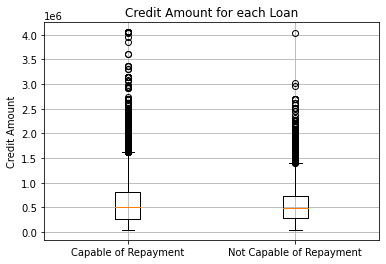

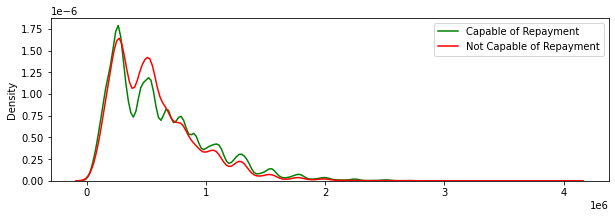

In [18]:
# 我们可以从上面的方框图中看到,有能力偿还贷款的客户的信贷金额中值略大于无能力偿还贷款客户的中值.
# 这基本上意味着,信用额度较高的客户比信用额度较低的客户有能力偿还贷款的机会略高.
approved_loan_credit = train_data[train_data['TARGET']==0]['AMT_CREDIT'].values
rejected_loan_credit = train_data[train_data['TARGET']==1]['AMT_CREDIT'].values
plt.boxplot([approved_loan_credit, rejected_loan_credit])
plt.title('Credit Amount for each Loan')
plt.xticks([1,2],('Capable of Repayment','Not Capable of Repayment'))
plt.ylabel('Credit Amount')
plt.grid()
plt.show()
# 我们可以观察到,大多数贷款的信贷金额都不到100万.
paint.distplot(data=train_data, col='AMT_CREDIT')

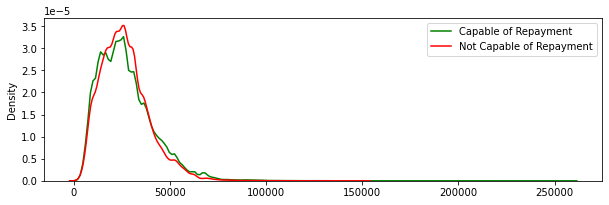

In [19]:
# 大多数人为贷款支付的年金低于5万
paint.distplot(data=train_data, col='AMT_ANNUITY')

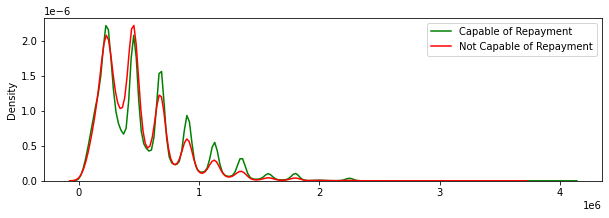

In [20]:
# 大多数贷款都是针对价格低于100万的人提供的.
paint.distplot(data=train_data, col='AMT_GOODS_PRICE')

['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']


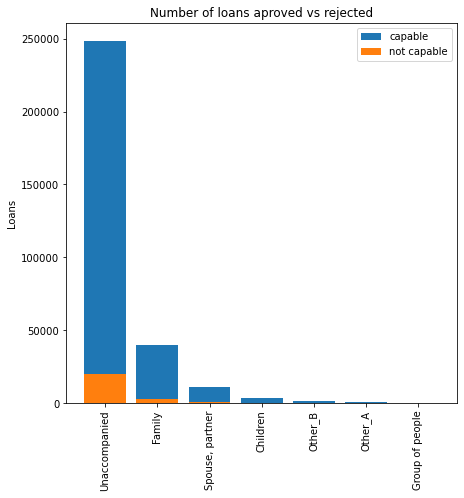

   NAME_TYPE_SUITE  TARGET   total       Avg
6    Unaccompanied   20337  248526  0.081830
1           Family    3009   40149  0.074946
5  Spouse, partner     895   11370  0.078716
0         Children     241    3267  0.073768
4          Other_B     174    1770  0.098305
   NAME_TYPE_SUITE  TARGET  total       Avg
5  Spouse, partner     895  11370  0.078716
0         Children     241   3267  0.073768
4          Other_B     174   1770  0.098305
3          Other_A      76    866  0.087760
2  Group of people      23    271  0.084871


In [21]:
# 从对于陪同客户贷款的各种类型的人的相关数据可以看出,在大多数情况下,客户都是独自来到银行的,
# 其中约92%的时间,银行认为客户有能力偿还贷款,而其余8%的时间,客户则没有能力偿还贷款.
# 无论是能偿还还是不能偿还,在这种情况下,“无人陪伴”作为一个类别是大多数类别.
# 这里的曲线下降得很厉害,这意味着有很多变化.
paint.univariate_barplots(data=train_data, col1='NAME_TYPE_SUITE', printUnique=True)

['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']


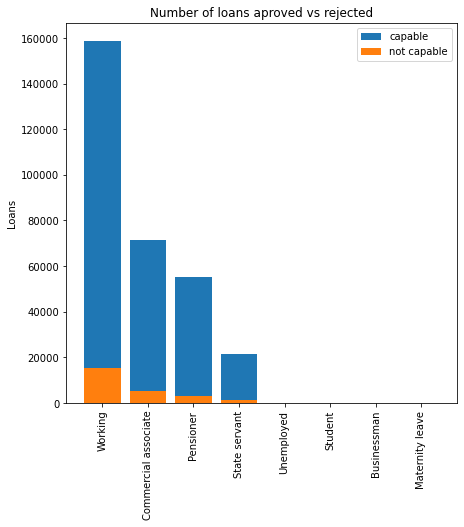

       NAME_INCOME_TYPE  TARGET   total       Avg
7               Working   15224  158774  0.095885
1  Commercial associate    5360   71617  0.074843
3             Pensioner    2982   55362  0.053864
4         State servant    1249   21703  0.057550
6            Unemployed       8      22  0.363636
  NAME_INCOME_TYPE  TARGET  total       Avg
4    State servant    1249  21703  0.057550
6       Unemployed       8     22  0.363636
5          Student       0     18  0.000000
0      Businessman       0     10  0.000000
2  Maternity leave       2      5  0.400000


In [22]:
# 在职人员获得的贷款数量最多,而商业合伙人、养老金领取者和国家公务员进行贷款的人数要少得多
# 我们几乎没有与失业人员、学生、商人和休产假妇女相关的数据点.同样,在这种情况下有很多种未知情况
# 这里一个有趣的观察结果是,无论学生和商人申请了多少贷款,他们都被认为有能力偿还
paint.univariate_barplots(data=train_data, col1='NAME_INCOME_TYPE', printUnique=True)

['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']


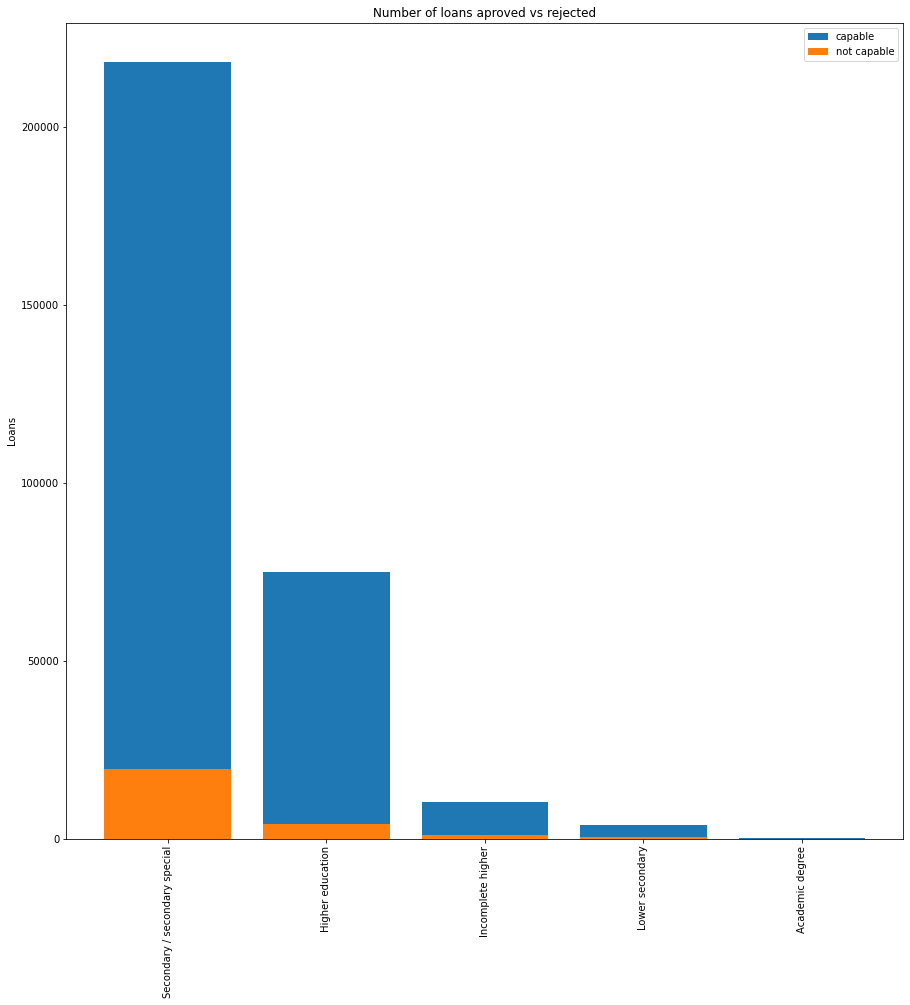

             NAME_EDUCATION_TYPE  TARGET   total       Avg
4  Secondary / secondary special   19524  218391  0.089399
1               Higher education    4009   74863  0.053551
2              Incomplete higher     872   10277  0.084850
3                Lower secondary     417    3816  0.109277
0                Academic degree       3     164  0.018293
             NAME_EDUCATION_TYPE  TARGET   total       Avg
4  Secondary / secondary special   19524  218391  0.089399
1               Higher education    4009   74863  0.053551
2              Incomplete higher     872   10277  0.084850
3                Lower secondary     417    3816  0.109277
0                Academic degree       3     164  0.018293


In [23]:
# 同样,不同教育类型的申请人有很大的差异.
# 中等/中等特殊教育程度最高的人申请贷款的人数最多,他们也是违约人数最多的人.
# 然而,不同教育水平的默认百分比差别不大.
paint.univariate_barplots(data=train_data, col1='NAME_EDUCATION_TYPE', printUnique=True)

['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']


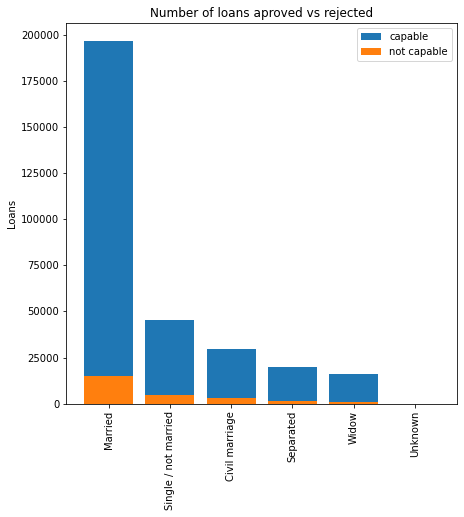

     NAME_FAMILY_STATUS  TARGET   total       Avg
1               Married   14850  196432  0.075599
3  Single / not married    4457   45444  0.098077
0        Civil marriage    2961   29775  0.099446
2             Separated    1620   19770  0.081942
5                 Widow     937   16088  0.058242
     NAME_FAMILY_STATUS  TARGET  total       Avg
3  Single / not married    4457  45444  0.098077
0        Civil marriage    2961  29775  0.099446
2             Separated    1620  19770  0.081942
5                 Widow     937  16088  0.058242
4               Unknown       0      2  0.000000


In [24]:
# 申请人的家庭状况存在差异,但如果忽略多数阶层(已婚),则差异不大.
# 已婚人士申请的贷款数量最多,被认定为无偿还能力的人数也最多.
paint.univariate_barplots(data=train_data, col1='NAME_FAMILY_STATUS', printUnique=True)

['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']


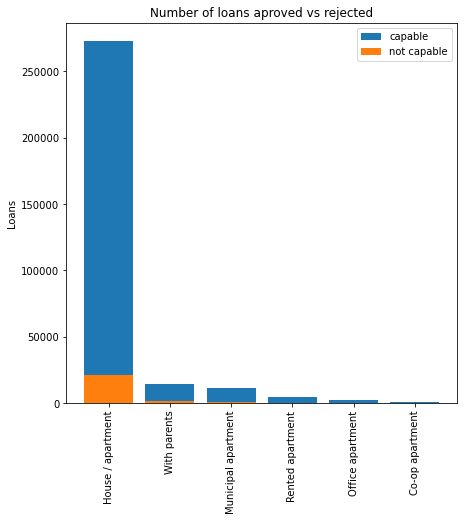

     NAME_HOUSING_TYPE  TARGET   total       Avg
1    House / apartment   21272  272868  0.077957
5         With parents    1736   14840  0.116981
2  Municipal apartment     955   11183  0.085397
4     Rented apartment     601    4881  0.123131
3     Office apartment     172    2617  0.065724
     NAME_HOUSING_TYPE  TARGET  total       Avg
5         With parents    1736  14840  0.116981
2  Municipal apartment     955  11183  0.085397
4     Rented apartment     601   4881  0.123131
3     Office apartment     172   2617  0.065724
0      Co-op apartment      89   1122  0.079323


In [25]:
# 住在房子/公寓里的人申请的贷款数量最多,在这种情况下被视为无能力还款的人数也最高,
# 而如果从百分比来看,住在租来的公寓里的人们违约的几率最高.
paint.univariate_barplots(data=train_data, col1='NAME_HOUSING_TYPE', printUnique=True)

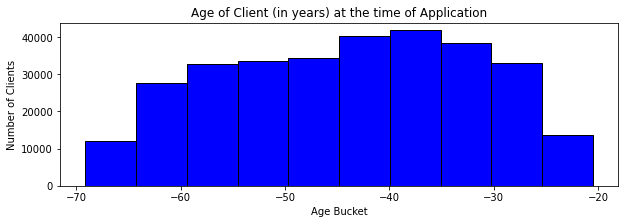

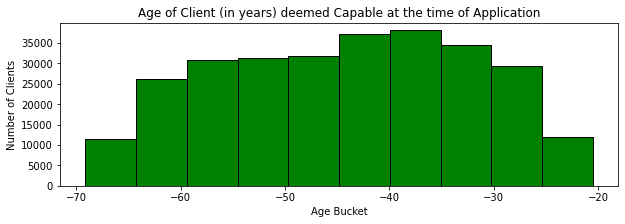

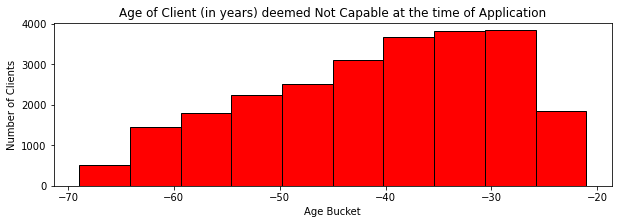

In [26]:
capable_days_birth = train_data[train_data['TARGET']==0]['DAYS_BIRTH'].values/365
not_capable_days_birth = train_data[train_data['TARGET']==1]['DAYS_BIRTH'].values/365
plt.figure(figsize=(10,3))
plt.hist(train_data['DAYS_BIRTH'].values/365, bins=10, edgecolor='black', color='blue')
plt.title('Age of Client (in years) at the time of Application')
plt.xlabel('Age Bucket')
plt.ylabel('Number of Clients')
plt.show()

plt.figure(figsize=(10,3))
plt.hist(capable_days_birth, bins=10, edgecolor='black', color='green')
plt.title('Age of Client (in years) deemed Capable at the time of Application')
plt.xlabel('Age Bucket')
plt.ylabel('Number of Clients')
plt.show()

plt.figure(figsize=(10,3))
plt.hist(not_capable_days_birth, bins=10, edgecolor='black', color='red')
plt.title('Age of Client (in years) deemed Not Capable at the time of Application')
plt.xlabel('Age Bucket')
plt.ylabel('Number of Clients')
plt.show()

# 大多数申请贷款的人年龄在(35-40)岁之间,其次是(40-45)岁之间的人,
# 而25岁以下或65岁以上的人申请贷款的人数非常少.
# 同样,对于被认为有能力偿还贷款的人来说,(35-40)岁和(40-45)岁年龄段的人被认为是最有能力的.
# 年龄在(25-30)岁和(30-35)岁之间的人很有可能被认为没有能力偿还贷款.

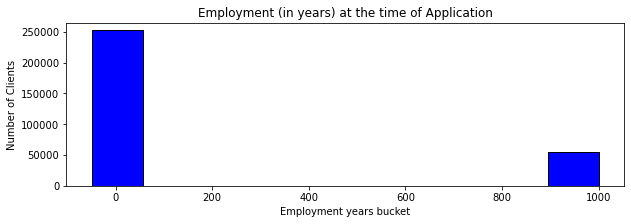

In [27]:
capable_days_employed = train_data[train_data['TARGET']==0]['DAYS_EMPLOYED'].values/365
not_capable_days_employed = train_data[train_data['TARGET']==1]['DAYS_EMPLOYED'].values/365
plt.figure(figsize=(10,3))
plt.hist(train_data['DAYS_EMPLOYED'].values/365, bins=10, edgecolor='black', color='blue')
plt.title('Employment (in years) at the time of Application')
plt.xlabel('Employment years bucket')
plt.ylabel('Number of Clients')
plt.show()
# 此外,为了便于分析,我们已经将天数转换为年,从直方图中可以看出,有些客户已经工作了1000年.
# 这显然是不可能的,而且是一个例外,我们将在稍后处理.

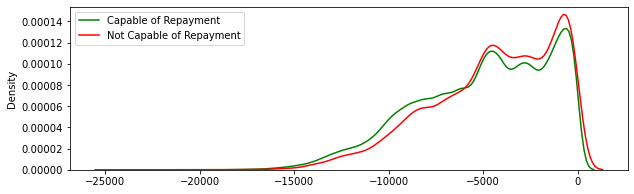

In [28]:
# 大多数客户在申请贷款前不到15000天(41年)更改了注册,
# 而在大多数情况下,更改注册的时间不到5000天(13年).
paint.distplot(data=train_data, col='DAYS_REGISTRATION')

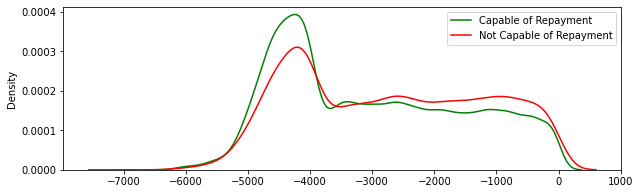

In [29]:
# 这基本上是指客户在申请日期前更改其申请贷款的身份证件的天数.
# 大多数客户在申请日期前4000天(10.95年)左右更改了身份证件.
paint.distplot(data=train_data, col='DAYS_ID_PUBLISH')

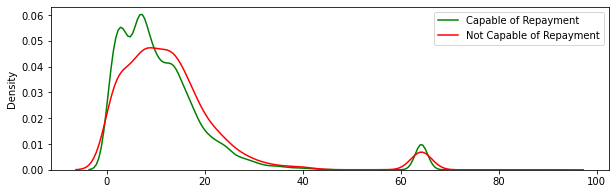

In [30]:
# 大多数客户的汽车使用年限不到20年,而很少有汽车使用年限超过20年.
paint.distplot(data=train_data, col='OWN_CAR_AGE')

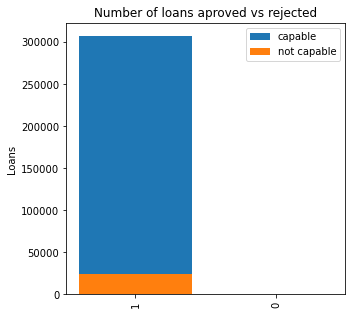

   FLAG_MOBIL  TARGET   total       Avg
1           1   24825  307510  0.080729
0           0       0       1  0.000000
   FLAG_MOBIL  TARGET   total       Avg
1           1   24825  307510  0.080729
0           0       0       1  0.000000


In [31]:
# 这是指示贷款申请人是否拥有手机.1表示拥有一部手机,而0表示没有手机.
# 在Train Data中的307511份贷款申请中,几乎每个申请中的人都拥有一部手机,
# 其中92%被认为有能力,8%被认为没有能力.
# 培训数据中只有1名申请人没有手机.
paint.univariate_barplots(data=train_data, col1='FLAG_MOBIL', fill=True)

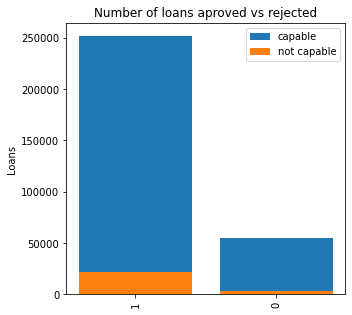

   FLAG_EMP_PHONE  TARGET   total       Avg
1               1   21834  252125  0.086600
0               0    2991   55386  0.054003
   FLAG_EMP_PHONE  TARGET   total       Avg
1               1   21834  252125  0.086600
0               0    2991   55386  0.054003


In [32]:
# 与没有提供工作电话的申请人(17%)相比,许多申请人提供了工作电话(83%).
paint.univariate_barplots(data=train_data, col1='FLAG_EMP_PHONE', fill=True)

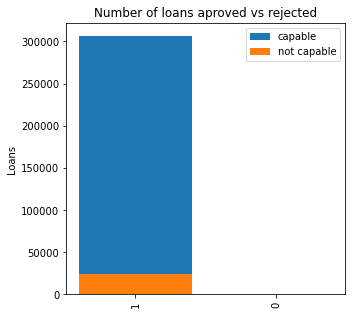

   FLAG_CONT_MOBILE  TARGET   total       Avg
1                 1   24780  306937  0.080733
0                 0      45     574  0.078397
   FLAG_CONT_MOBILE  TARGET   total       Avg
1                 1   24780  306937  0.080733
0                 0      45     574  0.078397


In [33]:
# 当银行试图联系99%的申请人时,他们的电话可以接通.
paint.univariate_barplots(data=train_data, col1='FLAG_CONT_MOBILE', fill=True)

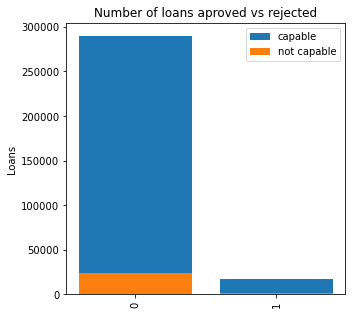

   FLAG_EMAIL  TARGET   total       Avg
0           0   23451  290069  0.080846
1           1    1374   17442  0.078775
   FLAG_EMAIL  TARGET   total       Avg
0           0   23451  290069  0.080846
1           1    1374   17442  0.078775


In [34]:
# 这进一步表明,大约94%的客户没有在应用程序中提供他们的电子邮件地址,只有6%的客户提供了电子邮件详细信息.
paint.univariate_barplots(data=train_data, col1='FLAG_EMAIL', fill=True)

['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers' 'Realty agents' 'Secretaries'
 'IT staff' 'HR staff']


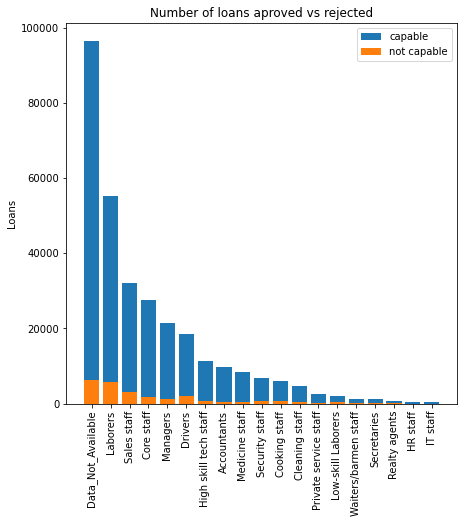

       OCCUPATION_TYPE  TARGET  total       Avg
4   Data_Not_Available    6278  96391  0.065131
9             Laborers    5838  55186  0.105788
15         Sales staff    3092  32102  0.096318
3           Core staff    1738  27570  0.063040
11            Managers    1328  21371  0.062140
         OCCUPATION_TYPE  TARGET  total       Avg
18  Waiters/barmen staff     152   1348  0.112760
16           Secretaries      92   1305  0.070498
14         Realty agents      59    751  0.078562
6               HR staff      36    563  0.063943
8               IT staff      34    526  0.064639


In [35]:
# 在所有可能的职业类型中,大多数申请人没有在申请中提供他们的职业类型(约31.39%),其次是劳动者(约18%).
# 在所有职业中,服务员/酒吧服务员被认为是还款能力最低的,
# 其次是劳动者->尽管与服务员/酒吧侍者相比,劳动者的申请要高得多.
paint.univariate_barplots(data=train_data, col1='OCCUPATION_TYPE', printUnique=True, fill=True)

2


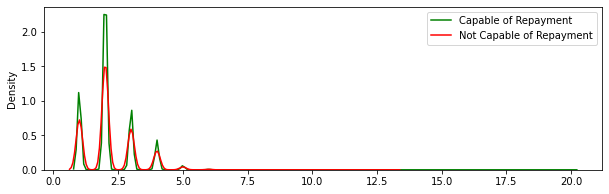

In [36]:
# 大多数申请人有2名家庭成员,很少有家庭成员超过5名的申请人.
print(train_data['CNT_FAM_MEMBERS'].isnull().sum())
paint.distplot(data=train_data, col='CNT_FAM_MEMBERS', fill=True)

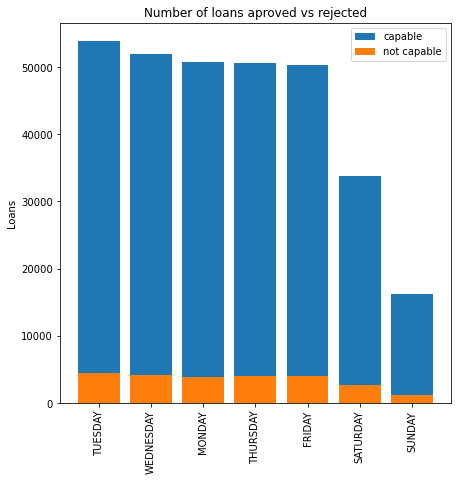

  WEEKDAY_APPR_PROCESS_START  TARGET  total       Avg
5                    TUESDAY    4501  53901  0.083505
6                  WEDNESDAY    4238  51934  0.081604
1                     MONDAY    3934  50714  0.077572
4                   THURSDAY    4098  50591  0.081003
0                     FRIDAY    4101  50338  0.081469
  WEEKDAY_APPR_PROCESS_START  TARGET  total       Avg
1                     MONDAY    3934  50714  0.077572
4                   THURSDAY    4098  50591  0.081003
0                     FRIDAY    4101  50338  0.081469
2                   SATURDAY    2670  33852  0.078873
3                     SUNDAY    1283  16181  0.079291


In [37]:
# 申请的时间几乎均匀分布在整个工作日(周一至周五),每天约5万份申请(16-17%),而周日的申请数量非常少.
paint.univariate_barplots(data=train_data, col1='WEEKDAY_APPR_PROCESS_START')

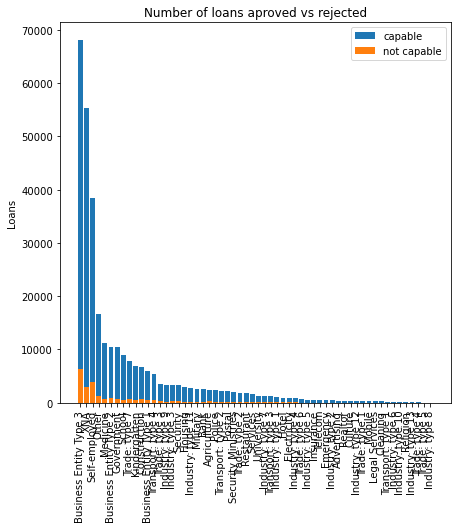

         ORGANIZATION_TYPE  TARGET  total       Avg
5   Business Entity Type 3    6323  67992  0.092996
57                     XNA    2990  55374  0.053996
42           Self-employed    3908  38412  0.101739
33                   Other    1275  16683  0.076425
30                Medicine     737  11193  0.065845
    ORGANIZATION_TYPE  TARGET  total       Avg
37           Religion       5     85  0.058824
18  Industry: type 13       9     67  0.134328
48      Trade: type 4       2     64  0.031250
49      Trade: type 5       3     49  0.061224
25   Industry: type 8       3     24  0.125000


In [38]:
# 商务人士和XNA（未提供信息）是申请人数最多的人，但商务人士和自雇申请人的违约率最高。
paint.univariate_barplots(data=train_data, col1='ORGANIZATION_TYPE')

173378


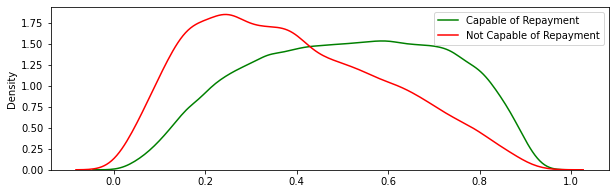

660


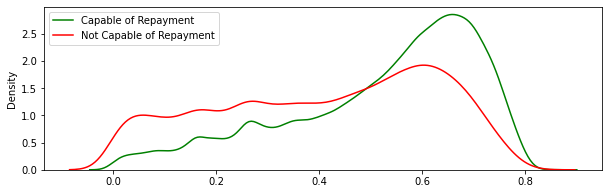

60965


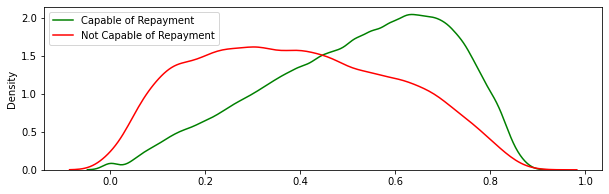

In [39]:
print(train_data['EXT_SOURCE_1'].isnull().sum())
# 这基本上表明,大约173378/307651,即EXT_SOURCE_1列中近56%的条目为null,
# 即空值,我们将只查看其余值.我们可以用整个数值列的平均值/中位数/模式来替换这些值,
# 但由于这是大量的零点,我们不会采用这种方法.
paint.distplot(data=train_data, col='EXT_SOURCE_1')
# 这是我们看到的第一个功能,正如我们从图中看到的那样,这两个类之间有很大的差异.
# 因此,EXT_SOURCE_1将成为一个重要功能.
print(train_data['EXT_SOURCE_2'].isnull().sum())
# 这基本上表明,大约660/307651,即该列中只有0.2%的条目为空.我们将分析列中的非空值.
paint.distplot(data=train_data, col='EXT_SOURCE_2')
# 同样,在这种情况下,我们也可以看到数据被很好地分离,因此这也是一个重要的特征.
print(train_data['EXT_SOURCE_3'].isnull().sum())
# 这基本上表明60965/3077511,即该列中19%的条目为null.我们将分析列中的非空值.
paint.distplot(data=train_data, col='EXT_SOURCE_3')
# 同样,数据被合理地很好地分离,因此这也是一个重要的特征.

In [40]:
# 训练和测试数据框架中有多个标志文件列,我们将对其进行分析,
# 以确定它们是否会为我们将要构建的模型增加更多价值.为了进行分析,
# 我们将首先从Dataframe中获取所有列的子集,该子集的列名中存在术语“FLAG”.
flag_document_df = train_data.loc[:, train_data.columns.str.contains('DOCUMENT')]
flag_document_df.head(5)
# 正如我们在这里看到的,我们在数据帧中总共有20个与不同文档相关的标志文档列,
# 其中1表示客户在贷款申请中提供了相应的文档,0表示客户没有提供相应的文档.
for column in flag_document_df:
    
    count_0 = flag_document_df[column].value_counts()[0]
    count_1 = flag_document_df[column].value_counts()[1]
    total_rows = flag_document_df.shape[0]
    
    percent_0 = np.round((count_0*100/total_rows),2)
    percent_1 = np.round(100 - percent_0,2)
    
    print(column, "contains percentage of 1's = ",percent_1,\
    "and percentage of 0's =", percent_0)
# 从这里我们可以看出,在大多数情况下,客户端已经提交了文档的百分比非常小,
# 这意味着数据是高度不平衡的,它在数据集中的存在对我们没有太大帮助.
# 然而,Flag_Document_3有较多数量的提交,我们可以删除除此之外的所有Flag_Document列.

FLAG_DOCUMENT_2 contains percentage of 1's =  0.0 and percentage of 0's = 100.0
FLAG_DOCUMENT_3 contains percentage of 1's =  71.0 and percentage of 0's = 29.0
FLAG_DOCUMENT_4 contains percentage of 1's =  0.01 and percentage of 0's = 99.99
FLAG_DOCUMENT_5 contains percentage of 1's =  1.51 and percentage of 0's = 98.49
FLAG_DOCUMENT_6 contains percentage of 1's =  8.81 and percentage of 0's = 91.19
FLAG_DOCUMENT_7 contains percentage of 1's =  0.02 and percentage of 0's = 99.98
FLAG_DOCUMENT_8 contains percentage of 1's =  8.14 and percentage of 0's = 91.86
FLAG_DOCUMENT_9 contains percentage of 1's =  0.39 and percentage of 0's = 99.61
FLAG_DOCUMENT_10 contains percentage of 1's =  0.0 and percentage of 0's = 100.0
FLAG_DOCUMENT_11 contains percentage of 1's =  0.39 and percentage of 0's = 99.61
FLAG_DOCUMENT_12 contains percentage of 1's =  0.0 and percentage of 0's = 100.0
FLAG_DOCUMENT_13 contains percentage of 1's =  0.35 and percentage of 0's = 99.65
FLAG_DOCUMENT_14 contains pe

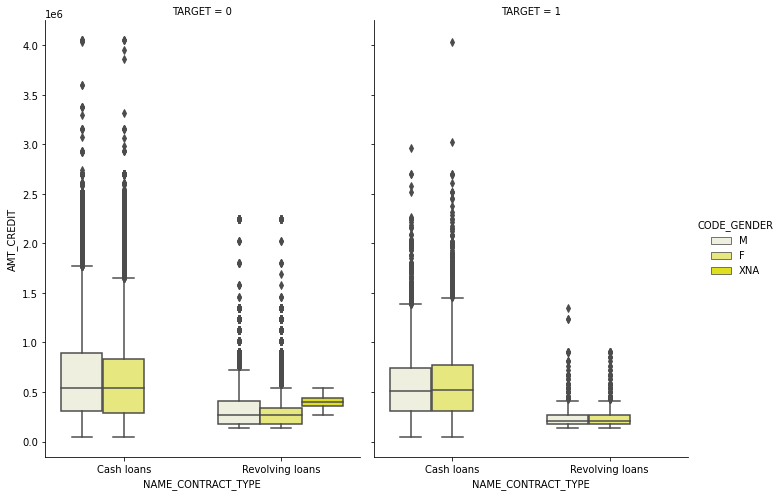

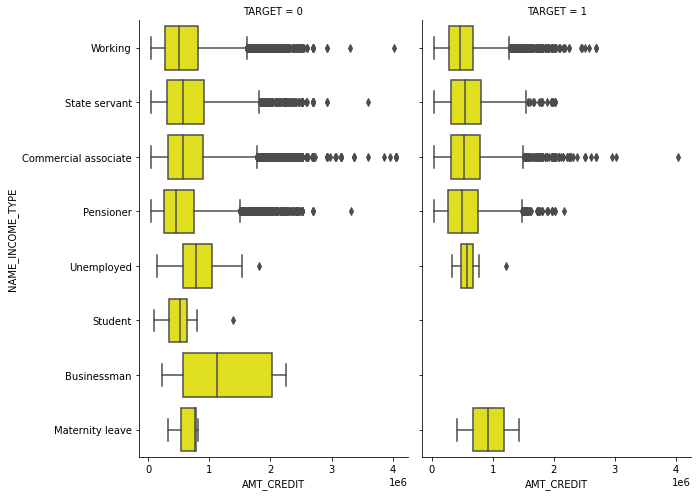

In [41]:
# 这表明,有现金贷款的男性和女性根据其信贷金额被认为有能力偿还贷款的几率更高
sns.catplot(x="NAME_CONTRACT_TYPE", y="AMT_CREDIT", hue="CODE_GENDER" ,col="TARGET",\
            data=train_data,color = "yellow",kind="box", height=7, aspect=.7);
# 这表明,在各种收入类型中,信贷金额价值较高的申请人被认为有能力偿还贷款的可能性更高
# 尤其对于“失业”、“学生”和“商人”
sns.catplot(x="AMT_CREDIT", y="NAME_INCOME_TYPE", col="TARGET",\
            data=train_data,color = "yellow",kind="box", height=7, aspect=.7);

<AxesSubplot:xlabel='AMT_CREDIT', ylabel='AMT_ANNUITY'>

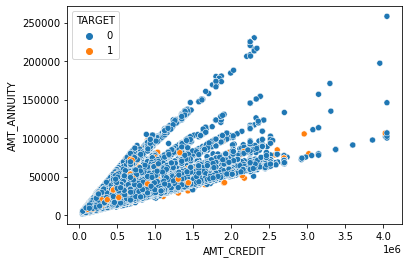

In [42]:
sns.scatterplot(
    data=train_data, x="AMT_CREDIT", y="AMT_ANNUITY", hue="TARGET",\
    sizes=(20, 200)
)
# 这表明信用额度和年金额度是直接成比例的.如果信贷金额很高,
# 那么相同的年金金额也会很高.
# 我们可以看到一个几乎是线性的图.然而,基于这两个数字特征,
# 我们无法在简单逻辑回归的帮助下进行二元分类.这意味着我们需要对其进行特征工程.

<h2> 4.4 ：修复空值和异常值</h2>

因为训练数据和测试数据相同，所以先组合两个数据集，然后从分类特征和数值列的离群值中过滤出NAs和不相关的类，然后再进行分类特征和手动特征工程的独热编码。

### 4.4.1 Days_Birth

In [43]:
print("The shape of the train dataset = ",train_data.shape)
train_data['DAYS_BIRTH'].describe()

The shape of the train dataset =  (307511, 122)


count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

In [44]:
print("The maximum age across all applicants (in years) = ",\
      - min(train_data['DAYS_BIRTH'].values)/365)

print("The minimum age across all applicants (in years) = ",\
      - max(train_data['DAYS_BIRTH'].values)/365)

The maximum age across all applicants (in years) =  69.12054794520547
The minimum age across all applicants (in years) =  20.517808219178082


<h4> 观察发现: </h4>

* 生日的最大值和最小值都可以接受，这个里面没有异常值

### 4.4.2 Days_Employed

'Days_Employed'这列指客户在贷款申请前开始他/她的这份工作的天数，所以所有值都必须为负，不能有任何正值。

In [45]:
train_data['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [46]:
print("The minimum employment across all applicants (in years) = ",\
        max(train_data['DAYS_EMPLOYED'].values)/365)

print("The maximum employment across all applicants (in years) = ",\
        min(train_data['DAYS_EMPLOYED'].values)/365)

The minimum employment across all applicants (in years) =  1000.6657534246575
The maximum employment across all applicants (in years) =  -49.07397260273972


<h4> Observations : </h4>

* 如图所示，以年为单位的(就业)最长时间是1000年，这显然是错的，将删除同一列中的所有正值。

In [47]:
train_data.replace(max(train_data['DAYS_EMPLOYED'].values), np.nan, inplace=True)

### 4.4.3 Days_Registration

Days_Registration也应该是非正值，我们将在本例中检查异常值。

In [48]:
train_data['DAYS_REGISTRATION'].describe()

count    307511.0
mean          NaN
std           NaN
min      -24672.0
25%       -7480.0
50%       -4504.0
75%       -2010.0
max           0.0
Name: DAYS_REGISTRATION, dtype: float64

In [49]:
print("The minimum days of registration across all applicants (in years) = ",\
        max(train_data['DAYS_EMPLOYED'].values)/365)

print("The maximum days of registration across all applicants (in years) = ",\
        min(train_data['DAYS_EMPLOYED'].values)/365)

The minimum days of registration across all applicants (in years) =  0.0
The maximum days of registration across all applicants (in years) =  -49.07397260273972


<h4> Observations : </h4>

* 这表明最小注册天数和最大注册天数都是可以接受的，并且在“Days_Registration”列中没有异常值。/
* 同时我们发现，describe函数里是不计算负数的mean和std的

### 4.4.4 移除异常值和空值

In [50]:
def fix_nulls_outliers(data):
        
    data['NAME_FAMILY_STATUS'].fillna('Data_Not_Available', inplace=True)
    data['NAME_HOUSING_TYPE'].fillna('Data_Not_Available', inplace=True)

    data['FLAG_MOBIL'].fillna('Data_Not_Available', inplace=True)
    data['FLAG_EMP_PHONE'].fillna('Data_Not_Available', inplace=True)
    data['FLAG_CONT_MOBILE'].fillna('Data_Not_Available', inplace=True)
    data['FLAG_EMAIL'].fillna('Data_Not_Available', inplace=True)

    data['OCCUPATION_TYPE'].fillna('Data_Not_Available', inplace=True)

    #Replace NA with the most frequently occuring class for Count of Client Family Members
    data['CNT_FAM_MEMBERS'].fillna(data['CNT_FAM_MEMBERS'].value_counts().idxmax(), \
                                             inplace=True)
        
    data.replace(max(data['DAYS_EMPLOYED'].values), np.nan, inplace=True)

    data['CODE_GENDER'].replace('XNA','M',inplace=True)
    #There are a total of 4 applicants with Gender provided as 'XNA'

    data['AMT_ANNUITY'].fillna(0, inplace=True)
    #A total of 36 datapoints are there where Annuity Amount is null.

    data['AMT_GOODS_PRICE'].fillna(0, inplace=True)
    #A total of 278 datapoints are there where Annuity Amount is null.

    data['NAME_TYPE_SUITE'].fillna('Unaccompanied', inplace=True)
    #Removing datapoints where 'Name_Type_Suite' is null.

    data['NAME_FAMILY_STATUS'].replace('Unknown','Married', inplace=True)
    #Removing datapoints where 'Name_Family_Status' is Unknown.

    data['OCCUPATION_TYPE'].fillna('Data_Not_Available', inplace=True)

    data['EXT_SOURCE_1'].fillna(0, inplace=True)
    data['EXT_SOURCE_2'].fillna(0, inplace=True)
    data['EXT_SOURCE_3'].fillna(0, inplace=True)
    
    return data

In [51]:
train_data = fix_nulls_outliers(train_data)
train_data.shape

(307511, 122)

<h2> 4.5 application_train的特征工程</h2>

上述，我们修复了“Application_Train”数据集中的空值和异常值，最后我们仍然总共有 307511 行和 122 列（包括 TARGET）。/

由于“Application_Train”由分类特征和数字特征组成，我们需要想出一些方法来处理分类特征。为此，我采用了一个热编码的策略，其功能如下:

In [52]:
# Refer :- https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction#Feature-Engineering
#通用函数（可用于对“Application_Train|test”执行特征工程）如下所示：
def FE_application_data(data):
    
    data['CREDIT_INCOME_PERCENT'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
    data['ANNUITY_INCOME_PERCENT'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    data['CREDIT_ANNUITY_PERCENT'] = data['AMT_CREDIT'] / data['AMT_ANNUITY']

    data['FAMILY_CNT_INCOME_PERCENT'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']
    data['CREDIT_TERM'] = data['AMT_ANNUITY'] / data['AMT_CREDIT']
    data['BIRTH_EMPLOYED_PERCENT'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
    data['CHILDREN_CNT_INCOME_PERCENT'] = data['AMT_INCOME_TOTAL']/data['CNT_CHILDREN']

    data['CREDIT_GOODS_DIFF'] = data['AMT_CREDIT'] - data['AMT_GOODS_PRICE']
    data['EMPLOYED_REGISTRATION_PERCENT'] = data['DAYS_EMPLOYED'] / data['DAYS_REGISTRATION']
    data['BIRTH_REGISTRATION_PERCENT'] = data['DAYS_BIRTH'] / data['DAYS_REGISTRATION']
    data['ID_REGISTRATION_DIFF'] = data['DAYS_ID_PUBLISH'] - data['DAYS_REGISTRATION']

    data['ANNUITY_LENGTH_EMPLOYED_PERCENT'] = data['CREDIT_TERM']/ data['DAYS_EMPLOYED']

    data['AGE_LOAN_FINISH'] = data['DAYS_BIRTH']*(-1.0/365) + \
                         (data['AMT_CREDIT']/data['AMT_ANNUITY']) *(1.0/12)
    # (This basically refers to the client's age when he/she finishes loan repayment)

    data['CAR_AGE_EMP_PERCENT'] = data['OWN_CAR_AGE']/data['DAYS_EMPLOYED']
    data['CAR_AGE_BIRTH_PERCENT'] = data['OWN_CAR_AGE']/data['DAYS_BIRTH']
    data['PHONE_CHANGE_EMP_PERCENT'] = data['DAYS_LAST_PHONE_CHANGE']/data['DAYS_EMPLOYED']
    data['PHONE_CHANGE_BIRTH_PERCENT'] = data['DAYS_LAST_PHONE_CHANGE']/data['DAYS_BIRTH']
    
    income_by_contract = data[['AMT_INCOME_TOTAL', 'NAME_CONTRACT_TYPE']].groupby('NAME_CONTRACT_TYPE').median()['AMT_INCOME_TOTAL']
    data['MEDIAN_INCOME_CONTRACT_TYPE'] = data['NAME_CONTRACT_TYPE'].map(income_by_contract)
    
    income_by_suite = data[['AMT_INCOME_TOTAL', 'NAME_TYPE_SUITE']].groupby('NAME_TYPE_SUITE').median()['AMT_INCOME_TOTAL']
    data['MEDIAN_INCOME_SUITE_TYPE'] = data['NAME_TYPE_SUITE'].map(income_by_suite)
    
    income_by_housing = data[['AMT_INCOME_TOTAL', 'NAME_HOUSING_TYPE']].groupby('NAME_HOUSING_TYPE').median()['AMT_INCOME_TOTAL']
    data['MEDIAN_INCOME_HOUSING_TYPE'] = data['NAME_HOUSING_TYPE'].map(income_by_housing)
    
    income_by_org = data[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']
    data['MEDIAN_INCOME_ORG_TYPE'] = data['ORGANIZATION_TYPE'].map(income_by_org)

    income_by_occu = data[['AMT_INCOME_TOTAL', 'OCCUPATION_TYPE']].groupby('OCCUPATION_TYPE').median()['AMT_INCOME_TOTAL']
    data['MEDIAN_INCOME_OCCU_TYPE'] = data['OCCUPATION_TYPE'].map(income_by_occu)

    income_by_education = data[['AMT_INCOME_TOTAL', 'NAME_EDUCATION_TYPE']].groupby('NAME_EDUCATION_TYPE').median()['AMT_INCOME_TOTAL']
    data['MEDIAN_INCOME_EDU_TYPE'] = data['NAME_EDUCATION_TYPE'].map(income_by_education)

    data['ORG_TYPE_INCOME_PERCENT'] = data['MEDIAN_INCOME_ORG_TYPE']/data['AMT_INCOME_TOTAL']
    data['OCCU_TYPE_INCOME_PERCENT'] = data['MEDIAN_INCOME_OCCU_TYPE']/data['AMT_INCOME_TOTAL']
    data['EDU_TYPE_INCOME_PERCENT'] = data['MEDIAN_INCOME_EDU_TYPE']/data['AMT_INCOME_TOTAL']

    data= data.drop(['FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7',
    'FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16','FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19',
    'FLAG_DOCUMENT_20','FLAG_DOCUMENT_21'],axis=1)

    cat_col = [category for category in data.columns if data[category].dtype == 'object']
    data = pd.get_dummies(data, columns= cat_col)
    
    return data

In [53]:
train_data_temp_1 = FE_application_data(train_data)
print(train_data_temp_1.shape)

(307511, 252)


特征数量从122个增加到252个

#### 对分类特征进行独热编码的函数:-

In [54]:
#Refer :- https://www.kaggle.com/jsaguiar/lightgbm-7th-place-solution
#one hot encode the categorical data
#学习：https://blog.csdn.net/yanghaoji/article/details/123734304

def one_hot_encode(df):
    original_columns = list(df.columns)
    categories = [cat for cat in df.columns if df[cat].dtype == 'object']
    df = pd.get_dummies(df, columns= categories, dummy_na= True) #one_hot_encode the categorical features
    categorical_columns = [cat for cat in df.columns if cat not in original_columns]
    return df, categorical_columns

<h1> 5. Bureau Dataset and Bureau Balance Datasets的特征工程 </h1>

*表的内容*\
*其他金融机构向征信局报告的客户以前的信用额度。\
*包含了征信局所拥有的全部记录

<h2>5.1. Bureau Data的基本概览</h2>

表包含有关当前申请人以前贷款申请的数据。这基本上意味着对于每个当前的申请人（即SK_ID_CURR），Bureau中存在一对多关系。\
为了将此数据与application主表合并，以“SK_ID_CURR”为主码合办它们。\
出于此目的使用了最小值、最大值、平均值、大小、总和、计数等聚合。

In [55]:
bureau_data = overview.reduce_memory_usage(pd.read_csv("F:/data/bureau.csv"))#改成自己的地址
print('Number of data points : ', bureau_data.shape[0])
print('Number of features : ', bureau_data.shape[1])
bureau_data.head()

Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 112.95 MB
Decreased by 49.3%
Number of data points :  1716428
Number of features :  17


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


Bureau中存在一对多关系（单个“SK_ID_CURR”，有多个“SK_ID_BUREAU”值。）

In [56]:
bureau_data.columns

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY'],
      dtype='object')

<h2> 5.2 Bureau数据集的分析</h2>

### 5.2.1 单变量分析:贷款活跃度CREDIT_ACTIVE

In [57]:
from collections import Counter
credit_active_counter = Counter()
for word in bureau_data['CREDIT_ACTIVE'].values:
    credit_active_counter.update(word.split(','))

print(credit_active_counter)

Counter({'Closed': 1079273, 'Active': 630607, 'Sold': 6527, 'Bad debt': 21})


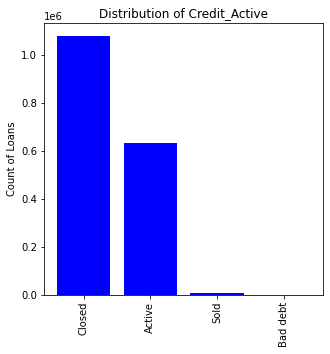

In [58]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
status_dict = dict(credit_active_counter)
sorted_status_dict = dict(sorted(status_dict.items(), key=lambda kv: kv[1], reverse=True))


ind = np.arange(len(sorted_status_dict))
plt.figure(figsize=(5,5))
p1 = plt.bar(ind, list(sorted_status_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Credit_Active')
plt.xticks(ind, list(sorted_status_dict.keys()),rotation=90)
plt.show()

<h4> 观察发现 : </h4>

* 大多数Bureau里的数据是Closed，其次是Active，SOld和Bad debt非常少

### 5.2.2 单变量分析：贷款前时长DAYS_CREDIT


Days_Credit列指的是客户申请局贷前的时间长度(单位为天)。 

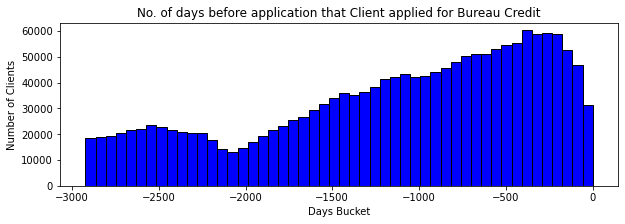

In [59]:
plt.figure(figsize=(10,3))
plt.hist(bureau_data['DAYS_CREDIT'].values, bins=50, edgecolor='black', color='blue')
plt.title('No. of days before application that Client applied for Bureau Credit')
plt.xlabel('Days Bucket')
plt.ylabel('Number of Clients')
plt.show()

<h4> 观察发现: </h4>

* 500天以内，大多数用户在征信局有过借贷记录

### 5.2.3 单变量分析：贷款逾期天数CREDIT_DAY_OVERDUE

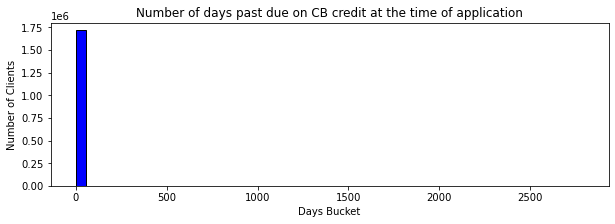

In [60]:
plt.figure(figsize=(10,3))
plt.hist(bureau_data['CREDIT_DAY_OVERDUE'].values, bins=50, edgecolor='black', color='blue')
plt.title('Number of days past due on CB credit at the time of application')
plt.xlabel('Days Bucket')
plt.ylabel('Number of Clients')
plt.show()

这表明大多数客户在申请时征信局DPD接近0。\
了进一步分析这一点，将看一下各自的百分位数，如下所示。 

In [61]:
y = PrettyTable()
y.field_names = ["Percentile", "No. of days past due on CB Credit"]

for i in range(0,101,10):
    y.add_row([i,np.percentile(bureau_data['CREDIT_DAY_OVERDUE'].values,i)])
print(y)

+------------+-----------------------------------+
| Percentile | No. of days past due on CB Credit |
+------------+-----------------------------------+
|     0      |                0.0                |
|     10     |                0.0                |
|     20     |                0.0                |
|     30     |                0.0                |
|     40     |                0.0                |
|     50     |                0.0                |
|     60     |                0.0                |
|     70     |                0.0                |
|     80     |                0.0                |
|     90     |                0.0                |
|    100     |               2792.0              |
+------------+-----------------------------------+


<h4> 观察发现 : </h4>

*90%之前，DPD依旧为0，而100%的值为2792。  
*进一步放大第99和第100百分位数之间的值。 

In [62]:
z = PrettyTable()
z.field_names = ["Percentile", "No. of days past due on CB Credit"]

for i in np.arange(99,100,0.1):
    z.add_row(np.round([i,np.percentile(bureau_data['CREDIT_DAY_OVERDUE'].values,i)],2))
print(z)

+------------+-----------------------------------+
| Percentile | No. of days past due on CB Credit |
+------------+-----------------------------------+
|    99.0    |                0.0                |
|    99.1    |                0.0                |
|    99.2    |                0.0                |
|    99.3    |                0.0                |
|    99.4    |                0.0                |
|    99.5    |                0.0                |
|    99.6    |                0.0                |
|    99.7    |                0.0                |
|    99.8    |                13.0               |
|    99.9    |               52.57               |
+------------+-----------------------------------+


<h4> 观察发现 : </h4>

* 只有99.7-100%分位的数是非零的

In [63]:
bureau_data[bureau_data['CREDIT_DAY_OVERDUE']>0].shape[0]
#This basically shows that there are a total of 4217 datapoints where the 'Credit_Day_Overdue' value is greater
#than 0.

4217

### 5.2.4 单变量分析：贷款类型CREDIT_TYPE

In [64]:
credit_type_counter = Counter()
for type in bureau_data['CREDIT_TYPE'].values:
    credit_type_counter.update(type.split(','))

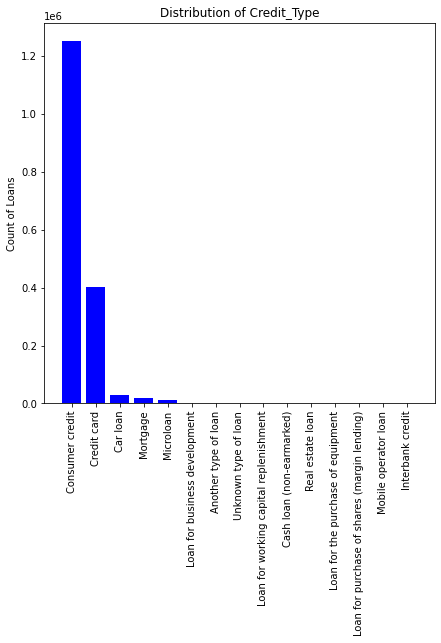

In [65]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
type_dict = dict(credit_type_counter)
sorted_type_dict = dict(sorted(type_dict.items(), key=lambda kv: kv[1], reverse=True))

ind_2 = np.arange(len(sorted_type_dict))
plt.figure(figsize=(7,7))
p1 = plt.bar(ind_2, list(sorted_type_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Credit_Type')
plt.xticks(ind_2, list(sorted_type_dict.keys()),rotation=90)
plt.show()

<h4> 观察发现: </h4>

* 消费信贷和信用卡是信用局登记的最多的信贷类型。

### 5.2.5 双变量分析:贷款活跃的Credit_Active 和 贷款前时长Days_Credit

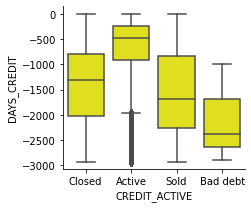

In [66]:
sns.catplot(x="CREDIT_ACTIVE", y="DAYS_CREDIT",\
            data=bureau_data,color = "yellow",kind="box", height=3, aspect=1.2);

<h4> 观察发现 : </h4>

* 这两个变量呈现显著的线性关系，贷款活跃度越高，贷款前时长越短

<h2>5.3. Bureau Balance Data基本概述 </h2>

In [67]:
bureau_balance = overview.reduce_memory_usage(pd.read_csv('F:/data/bureau_balance.csv'))
print('Number of data points : ', bureau_balance.shape[0])
print('Number of features : ', bureau_balance.shape[1])
bureau_balance.head()

Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 338.46 MB
Decreased by 45.8%
Number of data points :  27299925
Number of features :  3


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [68]:
bureau_balance.columns

Index(['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS'], dtype='object')

也是一个一对多的长数据

<h2> 5.4. Bureau Balance 数据分析 </h2>

### 5.4.1 单变量分析: Status状态

In [69]:
bureau_status_counter = Counter()
for status in bureau_balance['STATUS'].values:
    bureau_status_counter.update(status.split(','))

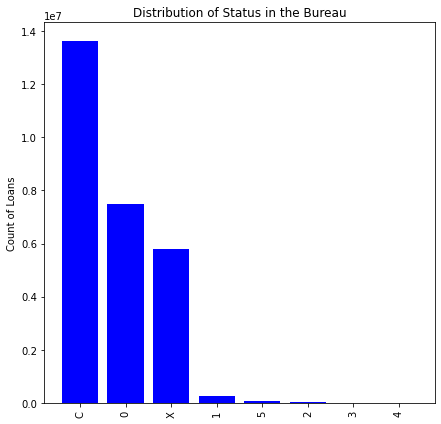

In [70]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
status_dict = dict(bureau_status_counter)
sorted_status_dict = dict(sorted(status_dict.items(), key=lambda kv: kv[1], reverse=True))


ind_3 = np.arange(len(sorted_status_dict))
plt.figure(figsize=(7,7))
p1 = plt.bar(ind_3, list(sorted_status_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Status in the Bureau')
plt.xticks(ind_3, list(sorted_status_dict.keys()),rotation=90)
plt.show()

<h4> 观察发现: </h4>

*大多数贷款都在信用局完成的，其次是DPD为0的客户，然后是身份不明的申请人。
*我们可以得出结论，数据中很少有年金违约者。

<h2> 5.5 Bureau Data and Bureau Balance Data的特征工程 </h2>

In [71]:
def generate_credit_type_code(x):
    if x == 'Closed':
        y = 0
    elif x=='Active':
        y = 1
    else:
        y = 2    
    return y


def FE_bureau_data_1(bureau_data):

    bureau_data['CREDIT_DURATION'] = -bureau_data['DAYS_CREDIT'] + bureau_data['DAYS_CREDIT_ENDDATE'] 
    bureau_data['ENDDATE_DIFF'] = bureau_data['DAYS_CREDIT_ENDDATE'] - bureau_data['DAYS_ENDDATE_FACT']
    bureau_data['UPDATE_DIFF'] = bureau_data['DAYS_CREDIT_ENDDATE'] - bureau_data['DAYS_CREDIT_UPDATE']
    bureau_data['DEBT_PERCENTAGE'] = bureau_data['AMT_CREDIT_SUM'] / bureau_data['AMT_CREDIT_SUM_DEBT']
    bureau_data['DEBT_CREDIT_DIFF'] = bureau_data['AMT_CREDIT_SUM'] - bureau_data['AMT_CREDIT_SUM_DEBT']
    bureau_data['CREDIT_TO_ANNUITY_RATIO'] = bureau_data['AMT_CREDIT_SUM'] / bureau_data['AMT_ANNUITY']
    bureau_data['DEBT_TO_ANNUITY_RATIO'] = bureau_data['AMT_CREDIT_SUM_DEBT'] / bureau_data['AMT_ANNUITY']
    bureau_data['CREDIT_OVERDUE_DIFF'] = bureau_data['AMT_CREDIT_SUM'] - bureau_data['AMT_CREDIT_SUM_OVERDUE']
    
    #Refer :- https://www.kaggle.com/c/home-credit-default-risk/discussion/57750
    #Calculating the Number of Past Loans for each Customer
    no_loans_per_customer = bureau_data[['SK_ID_CURR', 'SK_ID_BUREAU']].groupby(by = \
                                                                    ['SK_ID_CURR'])['SK_ID_BUREAU'].count()
    no_loans_per_customer = no_loans_per_customer.reset_index().rename(columns={'SK_ID_BUREAU': 'CUSTOMER_LOAN_COUNT'})
    bureau_data = bureau_data.merge(no_loans_per_customer, on='SK_ID_CURR', how='left')
    
    #Calculating the Past Credit Types per Customer
    credit_types_per_customer = bureau_data[['SK_ID_CURR','CREDIT_TYPE']].groupby(by=['SK_ID_CURR'])['CREDIT_TYPE'].nunique()
    credit_types_per_customer = credit_types_per_customer.reset_index().rename(columns={'CREDIT_TYPE':'CUSTOMER_CREDIT_TYPES'})
    bureau_data = bureau_data.merge(credit_types_per_customer, on='SK_ID_CURR',how='left')
    
    #Average Loan Type per Customer
    bureau_data['AVG_LOAN_TYPE'] = bureau_data['CUSTOMER_LOAN_COUNT']/bureau_data['CUSTOMER_CREDIT_TYPES']
    
    bureau_data['CREDIT_TYPE_CODE'] = bureau_data.apply(lambda x:\
                                        generate_credit_type_code(x.CREDIT_ACTIVE), axis=1)
    
    customer_credit_code_mean = bureau_data[['SK_ID_CURR','CREDIT_TYPE_CODE']].groupby(by=['SK_ID_CURR'])['CREDIT_TYPE_CODE'].mean()
    customer_credit_code_mean.reset_index().rename(columns={'CREDIT_TYPE_CODE':'CUSTOMER_CREDIT_CODE_MEAN'})
    bureau_data = bureau_data.merge(customer_credit_code_mean, on='SK_ID_CURR', how='left')
    
    #Computing the Ratio of Total Customer Credit and the Total Customer Debt
    bureau_data['AMT_CREDIT_SUM'] = bureau_data['AMT_CREDIT_SUM'].fillna(0)
    bureau_data['AMT_CREDIT_SUM_DEBT'] = bureau_data['AMT_CREDIT_SUM_DEBT'].fillna(0)
    bureau_data['AMT_ANNUITY'] = bureau_data['AMT_ANNUITY'].fillna(0)
    
    credit_sum_customer = bureau_data[['SK_ID_CURR','AMT_CREDIT_SUM']].groupby(by=\
                                                                            ['SK_ID_CURR'])['AMT_CREDIT_SUM'].sum()
    credit_sum_customer = credit_sum_customer.reset_index().rename(columns={'AMT_CREDIT_SUM':'TOTAL_CREDIT_SUM'})
    bureau_data = bureau_data.merge(credit_sum_customer, on='SK_ID_CURR', how='left')
                                      
    credit_debt_sum_customer = bureau_data[['SK_ID_CURR','AMT_CREDIT_SUM_DEBT']].groupby(by=\
                                                                        ['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum()
    credit_debt_sum_customer = credit_debt_sum_customer.reset_index().rename(columns={'AMT_CREDIT_SUM_DEBT':'TOTAL_DEBT_SUM'})
    bureau_data = bureau_data.merge(credit_debt_sum_customer, on='SK_ID_CURR', how='left')
    bureau_data['CREDIT_DEBT_RATIO'] = bureau_data['TOTAL_CREDIT_SUM']/bureau_data['TOTAL_DEBT_SUM']
    
    return bureau_data
    

In [72]:
bureau_data_fe = FE_bureau_data_1(bureau_data)

#One Hot Encoding the Bureau Datasets
bureau_data, bureau_data_columns = one_hot_encode(bureau_data_fe)
bureau_balance, bureau_balance_columns = one_hot_encode(bureau_balance)

In [73]:
def FE_bureau_data_2(bureau_data,bureau_balance,bureau_data_columns,bureau_balance_columns):

    bureau_balance_agg = {'MONTHS_BALANCE': ['min','max','mean','size']}
    
    for column in bureau_balance_columns:
        bureau_balance_agg[column] = ['min','max','mean','size']
        bureau_balance_final_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(bureau_balance_agg)
    
    col_list_1 =[]
    
    for col in bureau_balance_final_agg.columns.tolist():
        col_list_1.append(col[0] + "_" + col[1].upper())
    
    bureau_balance_final_agg.columns = pd.Index(col_list_1)
    bureau_data_balance = bureau_data.join(bureau_balance_final_agg, how='left', on='SK_ID_BUREAU')
    bureau_data_balance.drop(['SK_ID_BUREAU'], axis=1, inplace= True)

    del bureau_balance_final_agg
    gc.collect()


    numerical_agg = {'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],'AMT_CREDIT_SUM_OVERDUE': ['mean','sum'],
        'DAYS_CREDIT': ['mean', 'var'],'DAYS_CREDIT_UPDATE': ['mean','min'],'CREDIT_DAY_OVERDUE': ['mean','min'],
        'DAYS_CREDIT_ENDDATE': ['mean'],'CNT_CREDIT_PROLONG': ['sum'],'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],'AMT_CREDIT_MAX_OVERDUE': ['mean','max'],
        'AMT_ANNUITY': ['max', 'mean','sum'],'AMT_CREDIT_SUM': ['mean', 'sum','max']
      }
    categorical_agg = {}

    for col in bureau_data_columns:
        categorical_agg[col] = ['mean']
        categorical_agg[col] = ['max']

    for col in bureau_balance_columns:
        categorical_agg[col + "_MEAN"] = ['mean']
        categorical_agg[col + "_MIN"] = ['min']
        categorical_agg[col + "_MAX"] = ['max']
    
    bureau_data_balance_2 = bureau_data_balance.groupby('SK_ID_CURR').agg({**numerical_agg,\
                                                                       **categorical_agg})
    col_list_2=[]
    
    for col in bureau_data_balance_2.columns.tolist():
        col_list_2.append('BUREAU_'+col[0]+'_'+col[1])
    bureau_data_balance_2.columns = pd.Index(col_list_2)   


    bureau_data_balance_3 = bureau_data_balance[bureau_data_balance['CREDIT_ACTIVE_Active'] == 1]
    bureau_data_balance_3_agg = bureau_data_balance_3.groupby('SK_ID_CURR').agg(numerical_agg)

    col_list_3=[]
    for col in bureau_data_balance_3_agg.columns.tolist():
        col_list_3.append('A_'+col[0]+'_'+col[1].upper())

    bureau_data_balance_3_agg.columns = pd.Index(col_list_3)
    b3_final = bureau_data_balance_2.join(bureau_data_balance_3_agg, how='left', \
                                      on='SK_ID_CURR')

    bureau_data_balance_4 = bureau_data_balance[bureau_data_balance['CREDIT_ACTIVE_Closed'] == 1]
    bureau_data_balance_4_agg = bureau_data_balance_4.groupby('SK_ID_CURR').agg(numerical_agg)
    col_list_4 =[]
    
    for col in bureau_data_balance_4_agg.columns.tolist():
        col_list_4.append('C_'+col[0]+'_'+col[1].upper())

    bureau_data_balance_4_agg.columns = pd.Index(col_list_4)
    bureau_data_balance_final = bureau_data_balance_2.join(bureau_data_balance_4_agg, \
                                                    how='left', on='SK_ID_CURR')

    del bureau_data_balance_3, bureau_data_balance_4_agg
    gc.collect()
    
    return bureau_data_balance_final

In [74]:
bureau_data_balance_final = FE_bureau_data_2(bureau_data, bureau_balance,bureau_data_columns,bureau_balance_columns)
train_data_temp_2 = train_data_temp_1.join(bureau_data_balance_final, how='left',on='SK_ID_CURR')

del bureau_data_balance_final
gc.collect()

train_data_temp_2.shape

(307511, 353)

<h1> 6. Previous Application数据集 </h1>

<h2>6.1. Train Data概览 </h2>

In [75]:
previous_application = overview.reduce_memory_usage(pd.read_csv('F:/data/previous_application.csv'))
print('Number of data points : ', previous_application.shape[0])
print('Number of features : ', previous_application.shape[1])
previous_application.head()

Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 309.01 MB
Decreased by 34.5%
Number of data points :  1670214
Number of features :  37


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
previous_application.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

<h2> 6.2 Previous Application分析</h2>

### 6.2.1 单变量分析: Name_Cash_Loan_Purpose

In [77]:
application_loan_purpose = Counter()
for purpose in previous_application['NAME_CASH_LOAN_PURPOSE'].values:
    application_loan_purpose.update(purpose.split(','))

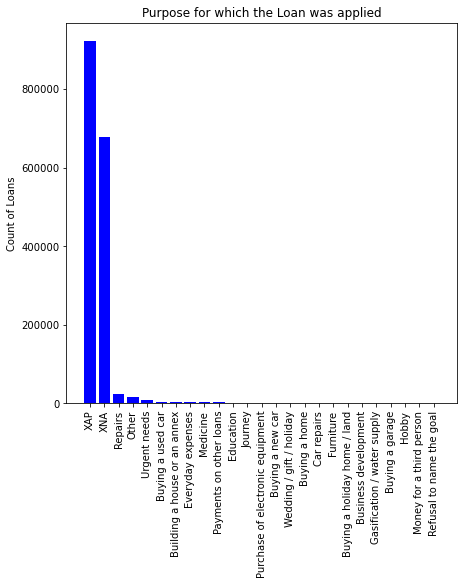

In [78]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
purpose_dict = dict(application_loan_purpose)
sorted_purpose_dict = dict(sorted(purpose_dict.items(), key=lambda kv: kv[1], reverse=True))

ind_4 = np.arange(len(sorted_purpose_dict))
plt.figure(figsize=(7,7))
p1 = plt.bar(ind_4, list(sorted_purpose_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Purpose for which the Loan was applied')
plt.xticks(ind_4, list(sorted_purpose_dict.keys()),rotation=90)
plt.show()

<h4> 观察发现: </h4>

*大多数贷款申请的目的是XAP，其次是XNA。根据官方给出的解释，XNA/XAP denote NA values.\
*这意味着申请人没有填此栏。

### 6.2.2 单变量分析: Name_Contract_Status

In [79]:
application_contract_status = Counter()
for status in previous_application['NAME_CONTRACT_STATUS'].values:
    application_contract_status.update(status.split(','))

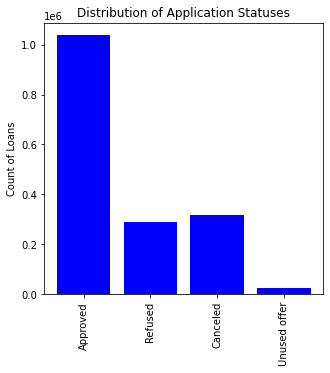

In [80]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
contract_status_dict = dict(application_contract_status)
sorted_contract_status_dict = dict(sorted(contract_status_dict.items(), \
                                        key=lambda kv: kv[1], reverse=True))

ind_5 = np.arange(len(contract_status_dict))
plt.figure(figsize=(5,5))
p1 = plt.bar(ind_5, list(contract_status_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Application Statuses')
plt.xticks(ind_5, list(contract_status_dict.keys()),rotation=90)
plt.show()

<h4> Observations : </h4>

* 客户以往的大部分申请均获批准，然后是被取消和拒绝。
* 还有一部分用户，获批但并未使用贷款。

### 6.2.3 单变量分析: Name_Payment_Type

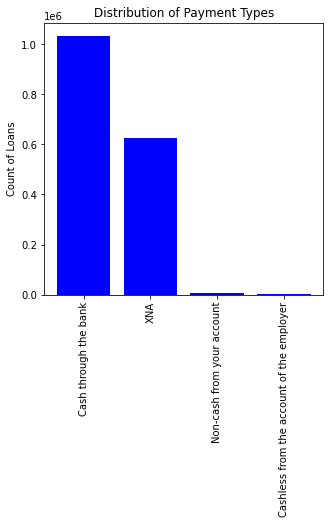

In [81]:
application_payment_type = Counter()
for type in previous_application['NAME_PAYMENT_TYPE'].values:
    application_payment_type.update(type.split(','))

# dict sort by value python: https://stackoverflow.com/a/613218/4084039
payment_type_dict = dict(application_payment_type)
sorted_payment_type_dict = dict(sorted(payment_type_dict.items(), \
                                        key=lambda kv: kv[1], reverse=True))

ind_6 = np.arange(len(payment_type_dict))
plt.figure(figsize=(5,5))
p1 = plt.bar(ind_6, list(payment_type_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Payment Types')
plt.xticks(ind_6, list(payment_type_dict.keys()),rotation=90)
plt.show()

### 6.2.4单变量分析: Code_Reject_Reason

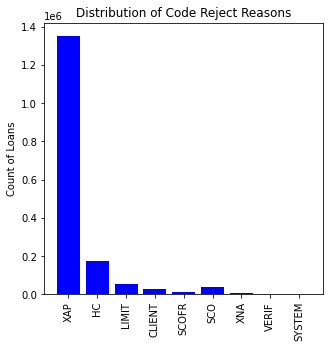

In [82]:
application_code_reject_reason = Counter()
for reason in previous_application['CODE_REJECT_REASON'].values:
    application_code_reject_reason.update(reason.split(','))

# dict sort by value python: https://stackoverflow.com/a/613218/4084039
code_reject_reason_dict = dict(application_code_reject_reason)
sorted_code_reject_reason_dict = dict(sorted(code_reject_reason_dict.items(), \
                                        key=lambda kv: kv[1], reverse=True))

ind_7 = np.arange(len(code_reject_reason_dict))
plt.figure(figsize=(5,5))
p1 = plt.bar(ind_7, list(code_reject_reason_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Code Reject Reasons')
plt.xticks(ind_7, list(code_reject_reason_dict.keys()),rotation=90)
plt.show()

<h4> Observations : </h4>

* 指客户之前的贷款申请被银行拒绝的原因。从这里可以看出，在大多数情况下，都没有写明详细原因
* 其次是HC，这是第二重要的原因。

### 6.2.5 单变量分析: Name_Client_Type

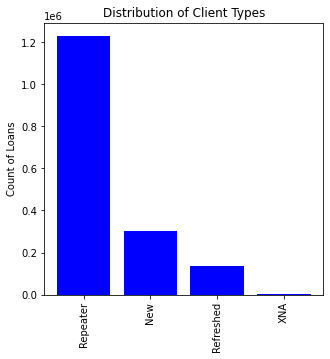

In [83]:
application_client_type = Counter()
for type in previous_application['NAME_CLIENT_TYPE'].values:
    application_client_type.update(type.split(','))

# dict sort by value python: https://stackoverflow.com/a/613218/4084039
client_type_dict = dict(application_client_type)
sorted_client_type_dict = dict(sorted(client_type_dict.items(), \
                                        key=lambda kv: kv[1], reverse=True))

ind_8 = np.arange(len(client_type_dict))
plt.figure(figsize=(5,5))
p1 = plt.bar(ind_8, list(client_type_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Client Types')
plt.xticks(ind_8, list(client_type_dict.keys()),rotation=90)
plt.show()

<h4> Observations : </h4>

* 列定义了客户端在申请以前的申请是旧的还是新的。我们可以看到，之前申请的大多数申请都是再贷款，第一次申请的人很少。

### 6.2.6 单变量: Name_Goods_Category

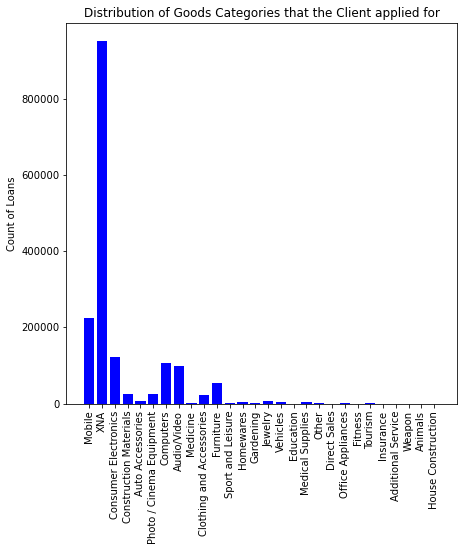

In [84]:
application_goods_category = Counter()
for category in previous_application['NAME_GOODS_CATEGORY'].values:
    application_goods_category.update(category.split(','))

# dict sort by value python: https://stackoverflow.com/a/613218/4084039
goods_category_dict = dict(application_goods_category)
sorted_goods_category = dict(sorted(goods_category_dict.items(), \
                                        key=lambda kv: kv[1], reverse=True))

ind_9 = np.arange(len(goods_category_dict))
plt.figure(figsize=(7,7))
p1 = plt.bar(ind_9, list(goods_category_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Goods Categories that the Client applied for')
plt.xticks(ind_9, list(goods_category_dict.keys()),rotation=90)
plt.show()

<h4> Observations : </h4>

* 记录了贷款人之前申请贷款使用的对象, 大多数人没有选择，其次是手机

### 6.2.7 单变量分析: Name_Portfolio

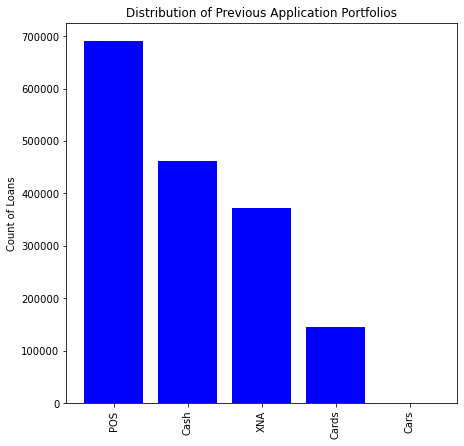

In [85]:
application_name_portfolio = Counter()
for name in previous_application['NAME_PORTFOLIO'].values:
    application_name_portfolio.update(name.split(','))

# dict sort by value python: https://stackoverflow.com/a/613218/4084039
application_name_dict = dict(application_name_portfolio)
sorted_name_portfolio = dict(sorted(application_name_dict.items(), \
                                        key=lambda kv: kv[1], reverse=True))

ind_10 = np.arange(len(application_name_dict))
plt.figure(figsize=(7,7))
p1 = plt.bar(ind_10, list(application_name_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Previous Application Portfolios')
plt.xticks(ind_10, list(application_name_dict.keys()),rotation=90)
plt.show()

<h4> Observations : </h4>

* 这表明之前大多数申请的是通过POS机、现金、未填写、信用卡

### 6.2.8 单变量分析: Channel_Type

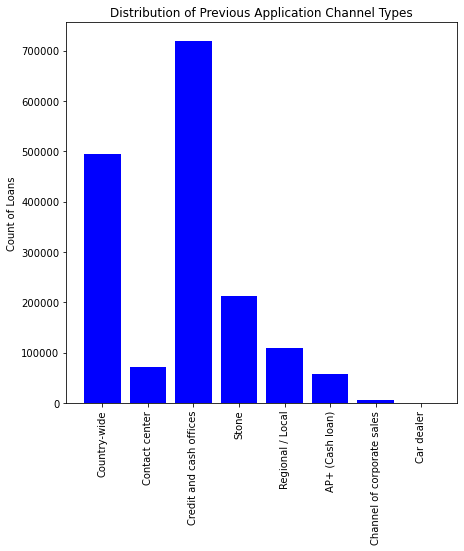

In [86]:
application_channel_type = Counter()
for type in previous_application['CHANNEL_TYPE'].values:
    application_channel_type.update(type.split(','))

# dict sort by value python: https://stackoverflow.com/a/613218/4084039
channel_type_dict = dict(application_channel_type)
sorted_channel_type = dict(sorted(application_channel_type.items(), \
                                        key=lambda kv: kv[1], reverse=True))

ind_11 = np.arange(len(channel_type_dict))
plt.figure(figsize=(7,7))
p1 = plt.bar(ind_11, list(channel_type_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Previous Application Channel Types')
plt.xticks(ind_11, list(channel_type_dict.keys()),rotation=90)
plt.show()

<h4> 观察发现 : </h4>

* 银行在之前的申请中获得的客户大部分是通过信贷和现金营业部获得的，其次是全国范围的。

### 6.2.9 单变量分析: Nflag_Insured_on_Approval

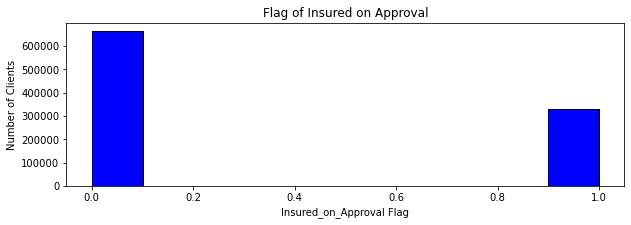

In [87]:
plt.figure(figsize=(10,3))
plt.hist(previous_application['NFLAG_INSURED_ON_APPROVAL'].values, bins=10, \
         edgecolor='black', color='blue')
plt.title('Flag of Insured on Approval')
plt.xlabel('Insured_on_Approval Flag')
plt.ylabel('Number of Clients')
plt.show()

<h4> 观察发现: </h4>

* 在之前的申请中申请保险的客户比没有申请保险的客户要少得多。

<h2> 6.3 处理空值和异常值 </h2>

除非值为负值，否则无法找到金额和现金相关特征的异常值。除此之外，尝试处理剩下的因子

<h3> 6.3.1 Days_Decision </h3>

这个特征指对前一个申请做出的决定到当前申请的天数。

In [88]:
previous_application['DAYS_DECISION'].describe()

count    1.670214e+06
mean    -8.806797e+02
std      7.790997e+02
min     -2.922000e+03
25%     -1.300000e+03
50%     -5.810000e+02
75%     -2.800000e+02
max     -1.000000e+00
Name: DAYS_DECISION, dtype: float64

In [89]:
print("The maximum Days_Decision (in years) across all applications = ",\
      - min(previous_application['DAYS_DECISION'].values)/365)

print("The minimum Days_Decision (in years) across all applications = ",\
      - max(previous_application['DAYS_DECISION'].values)/365)

The maximum Days_Decision (in years) across all applications =  8.005479452054795
The minimum Days_Decision (in years) across all applications =  0.0027397260273972603


<h4> Observations : </h4>

* 没有异常值

<h3> 6.3.2 Days_First_Drawing </h3>

这个特征表示相对于当前申请的申请日期，何时执行了先前申请的首次付款。

In [90]:
previous_application['DAYS_FIRST_DRAWING'].describe()

count    997149.000000
mean     340114.343750
std       88611.609375
min       -2922.000000
25%      365243.000000
50%      365243.000000
75%      365243.000000
max      365243.000000
Name: DAYS_FIRST_DRAWING, dtype: float64

In [91]:
print("The maximum Days_First_Drawing (in years) across all applications = ",\
       max(previous_application['DAYS_FIRST_DRAWING'].values)/365)

print("The minimum Days_First_Drawing (in years) across all applications = ",\
       min(previous_application['DAYS_FIRST_DRAWING'].values)/365)

The maximum Days_First_Drawing (in years) across all applications =  1000.6657534246575
The minimum Days_First_Drawing (in years) across all applications =  -8.005479452054795


<h4> 这表明</h4>

Days_First_Drawing的最大值比当前应用程序早1000年，这显然是不可能的。此外，由于该特征的第25、第50和第75百分位值与所有特征的最大值相同，因此我们将首先处理删除该最大值的问题。

In [92]:
previous_application['DAYS_FIRST_DRAWING'].replace(max(previous_application['DAYS_FIRST_DRAWING'].values),\
                                                  np.nan, inplace=True)

In [93]:
previous_application['DAYS_FIRST_DRAWING'].describe()

count    62705.000000
mean     -1035.251709
std        922.704407
min      -2922.000000
25%      -1721.000000
50%       -621.000000
75%       -303.000000
max         -2.000000
Name: DAYS_FIRST_DRAWING, dtype: float64

<h4> Observations : </h4>

* 现在最大值和最小值都是可以接受的

<h3> 6.3.3 Days_First_Due </h3>

Days_First_Due表示相对于当前应用程序的申请日期，前一个应用程序的第一个截止日期应该是什么时候。

In [94]:
previous_application['DAYS_FIRST_DUE'].describe()

count    997149.000000
mean      13838.132812
std       72421.296875
min       -2892.000000
25%       -1628.000000
50%        -831.000000
75%        -411.000000
max      365243.000000
Name: DAYS_FIRST_DUE, dtype: float64

In [95]:
previous_application['DAYS_FIRST_DUE'].replace(np.nan,0, inplace= True)

print("The minimum Days_First_Due (in years) across all applications = ",\
       min(previous_application['DAYS_FIRST_DUE'].values)/365)

print("The maximum Days_First_Due (in years) across all applications = ",\
       max(previous_application['DAYS_FIRST_DUE'].values)/365)

previous_application['DAYS_FIRST_DUE'].replace(0,np.nan, inplace= True)

The minimum Days_First_Due (in years) across all applications =  -7.923287671232877
The maximum Days_First_Due (in years) across all applications =  1000.6657534246575


<h4> Note </h4>
Days_First_Due的最大值比当前应用程序早1000年，这显然是不可能的。因此，我们将首先处理删除该特性中的最大值。

In [96]:
previous_application['DAYS_FIRST_DUE'].replace(max(previous_application['DAYS_FIRST_DUE'].values),\
                                                  np.nan, inplace=True)
previous_application['DAYS_FIRST_DUE'].describe()

count    956504.000000
mean      -1106.573364
std         790.587769
min       -2892.000000
25%       -1676.000000
50%        -874.000000
75%        -459.000000
max          -2.000000
Name: DAYS_FIRST_DUE, dtype: float64

<h4> Observations : </h4>

* 值正常

<h3> 6.3.4 Days_Last_Due_1st_Version </h3>

这个特征表示相对于当前申请的申请日期，前一个申请的第一个截止日期是什么时候。

In [97]:
previous_application['DAYS_LAST_DUE_1ST_VERSION'].describe()

count    997149.000000
mean      33764.871094
std      106544.812500
min       -2801.000000
25%       -1242.000000
50%        -361.000000
75%         129.000000
max      365243.000000
Name: DAYS_LAST_DUE_1ST_VERSION, dtype: float64

In [98]:
previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace(np.nan,0, inplace= True)

print("The minimum Days_Last_Due_1st_Version (in years) across all applications = ",\
       np.round(min(previous_application['DAYS_LAST_DUE_1ST_VERSION'].values)/365,3))

print("The maximum Days_Last_Due_1st_Version (in years) across all applications = ",\
       np.round(max(previous_application['DAYS_LAST_DUE_1ST_VERSION'].values)/365,3))

previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace(0,np.nan, inplace= True)

The minimum Days_Last_Due_1st_Version (in years) across all applications =  -7.674
The maximum Days_Last_Due_1st_Version (in years) across all applications =  1000.666


<h4> Note </h4>
表中的最大Days_Last_Due_1st_Version比当前应用程序早1000年，这显然是不可能的。因此，我们将首先处理删除该特性中的最大值。

In [99]:
previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace(max(previous_application['DAYS_LAST_DUE_1ST_VERSION'].values),\
                                                  np.nan, inplace=True)
previous_application['DAYS_LAST_DUE_1ST_VERSION'].describe()

count    902580.000000
mean       -677.701843
std         923.615356
min       -2801.000000
25%       -1360.000000
50%        -481.000000
75%          -2.000000
max        2389.000000
Name: DAYS_LAST_DUE_1ST_VERSION, dtype: float64

<h4> Observations : </h4>

*值是合理的

<h3> 6.3.5 Days_Last_Due </h3>

Days_Last_Due表示相对于当前申请的申请日期，上一次申请的最后到期日是什么时候。

In [100]:
previous_application['DAYS_LAST_DUE'].describe()

count    997149.000000
mean      76829.148438
std      150155.109375
min       -2889.000000
25%       -1314.000000
50%        -537.000000
75%         -74.000000
max      365243.000000
Name: DAYS_LAST_DUE, dtype: float64

In [101]:
previous_application['DAYS_LAST_DUE'].replace(np.nan,0, inplace= True)

print("The minimum Days_Last_Due (in years) across all applications = ",\
       np.round(min(previous_application['DAYS_LAST_DUE'].values)/365,3))

print("The maximum Days_Last_Due (in years) across all applications = ",\
       np.round(max(previous_application['DAYS_LAST_DUE'].values)/365,3))

previous_application['DAYS_LAST_DUE'].replace(0,np.nan, inplace= True)

The minimum Days_Last_Due (in years) across all applications =  -7.915
The maximum Days_Last_Due (in years) across all applications =  1000.666


<h4> Note </h4>

这意味着表中Days_Last_Due的最大值比当前应用程序早1000年，这是不可能的。因此，我们将首先处理删除该特性中的最大值。

In [102]:
previous_application['DAYS_LAST_DUE'].replace(max(previous_application['DAYS_LAST_DUE'].values),\
                                                  np.nan, inplace=True)
previous_application['DAYS_LAST_DUE'].describe()

count    785928.000000
mean       -996.137085
std         752.599609
min       -2889.000000
25%       -1566.000000
50%        -801.000000
75%        -353.000000
max          -2.000000
Name: DAYS_LAST_DUE, dtype: float64

<h4> Observations : </h4>

*在这里，我们可以看到Days_Last_Due的最小值和最大值都是允许的(两者相对于当前应用程序都是负值)。

<h3> 6.3.6 Days_Termination </h3>

Days_Termination表示相对于当前应用程序的申请日期，前一个应用程序的预期终止时间是什么时候。

In [103]:
previous_application['DAYS_TERMINATION'].describe()

count    997149.00000
mean      82314.84375
std      152926.93750
min       -2874.00000
25%       -1270.00000
50%        -499.00000
75%         -44.00000
max      365243.00000
Name: DAYS_TERMINATION, dtype: float64

In [104]:
previous_application['DAYS_TERMINATION'].replace(np.nan,0, inplace= True)

print("The minimum Days_Termination (in years) across all applications = ",\
       np.round(min(previous_application['DAYS_TERMINATION'].values)/365,3))

print("The maximum Days_Termination (in years) across all applications = ",\
       np.round(max(previous_application['DAYS_TERMINATION'].values)/365,3))

previous_application['DAYS_TERMINATION'].replace(0,np.nan, inplace= True)

The minimum Days_Termination (in years) across all applications =  -7.874
The maximum Days_Termination (in years) across all applications =  1000.666


<h4> Note </h4>
同上

In [105]:
previous_application['DAYS_TERMINATION'].replace(max(previous_application['DAYS_TERMINATION'].values),\
                                                  np.nan, inplace=True)
previous_application['DAYS_TERMINATION'].describe()

count    771236.000000
mean       -978.317993
std         749.048645
min       -2874.000000
25%       -1539.000000
50%        -780.000000
75%        -337.000000
max          -2.000000
Name: DAYS_TERMINATION, dtype: float64

<h4> Observations : </h4>

* 同上

<h2> 6.4 Previous Application的特征工程 </h2>

<h4> 对多个特征进行特征工程 </h4>

In [106]:
def FE_previous_application(previous_application):
    
    prev_app, previous_application_columns = one_hot_encode(previous_application)
    
    prev_app['APPLICATION_CREDIT_DIFF'] = prev_app['AMT_APPLICATION'] - prev_app['AMT_CREDIT']
    prev_app['APPLICATION_CREDIT_RATIO'] = prev_app['AMT_APPLICATION'] / prev_app['AMT_CREDIT']
    prev_app['CREDIT_TO_ANNUITY_RATIO'] = prev_app['AMT_CREDIT']/prev_app['AMT_ANNUITY']
    prev_app['DOWN_PAYMENT_TO_CREDIT'] = prev_app['AMT_DOWN_PAYMENT'] / prev_app['AMT_CREDIT']

    total_payment = prev_app['AMT_ANNUITY'] * prev_app['CNT_PAYMENT']
    prev_app['SIMPLE_INTERESTS'] = (total_payment/prev_app['AMT_CREDIT'] - 1)/prev_app['CNT_PAYMENT']

    prev_app['DAYS_LAST_DUE_DIFF'] = prev_app['DAYS_LAST_DUE_1ST_VERSION'] - prev_app['DAYS_LAST_DUE']

    numerical_agg_prev = {'AMT_ANNUITY': ['max', 'mean'], 'AMT_APPLICATION': ['max','mean'],\
                     'AMT_CREDIT':['max','mean'], 'AMT_DOWN_PAYMENT': ['max','mean'],\
                      'AMT_GOODS_PRICE':['mean','sum'], 'HOUR_APPR_PROCESS_START' :\
                      ['max','mean'], 'RATE_DOWN_PAYMENT':['max','mean'], 'RATE_INTEREST_PRIMARY':\
                      ['max','mean'],'RATE_INTEREST_PRIVILEGED':['max','mean'], \
                      'DAYS_DECISION': ['max','mean'], 'CNT_PAYMENT' :['mean','sum'], \
                      'DAYS_FIRST_DRAWING': ['max','mean'], 'DAYS_TERMINATION' : ['max','mean'],\
                      'APPLICATION_CREDIT_RATIO': ['max','mean'], 'DOWN_PAYMENT_TO_CREDIT' : \
                      ['max','mean'], 'DAYS_LAST_DUE_DIFF': ['max','mean']}

    categorical_agg_prev = {}
    
    for column in previous_application_columns:
        categorical_agg_prev[column] = ['mean']
    
    prev_app_agg1 = prev_app.groupby('SK_ID_CURR').agg({**numerical_agg_prev, \
                                                    **categorical_agg_prev})
    col_list_5 =[]
    
    for col in prev_app_agg1.columns.tolist():
        col_list_5.append('PREV_'+col[0]+'_'+col[1].upper())

    prev_app_agg1.columns = pd.Index(col_list_5)
    
    prev_app_cs_approved = prev_app[prev_app['NAME_CONTRACT_STATUS_Approved']==1]
    prev_app_agg2 = prev_app_cs_approved.groupby('SK_ID_CURR').agg(numerical_agg_prev)

    col_list_6 = []

    for col in prev_app_agg2.columns.tolist():
        col_list_6.append('CS_APP_' + col[0] + '_' + col[1].upper())
    
    prev_app_agg2.columns = pd.Index(col_list_6)
    
    prev_app_agg1_join = prev_app_agg1.join(prev_app_agg2, how='left', on='SK_ID_CURR')

    prev_app_cs_refused = prev_app[prev_app['NAME_CONTRACT_STATUS_Refused']==1]
    prev_app_agg3 = prev_app_cs_refused.groupby('SK_ID_CURR').agg(numerical_agg_prev)
    
    col_list_7 =[]

    for col in prev_app_agg3.columns.tolist():
        col_list_7.append('CS_REF_' + col[0] + '_' + col[1].upper())

    prev_app_agg3.columns = pd.Index(col_list_7)
    prev_app_agg_final = prev_app_agg1_join.join(prev_app_agg3,how='left', on='SK_ID_CURR')
    
    del prev_app_agg1_join, prev_app_agg3, prev_app_cs_refused, prev_app_agg1, prev_app_agg2,\
        prev_app_cs_approved
    gc.collect()
    return prev_app_agg_final

<h4> 函数进行特征工程使用'Days_Decision' </h4>

In [107]:
def FE_previous_application_days_decision(data,data_temp,previous_application):
    
    temp_1 = FE_previous_application(overview.reduce_memory_usage(previous_application))
    data = data_temp.merge(temp_1, how='left', on='SK_ID_CURR')
    del temp_1
    gc.collect()

    temp_2 = overview.reduce_memory_usage(previous_application[previous_application['DAYS_DECISION']>=-365].reset_index())
    temp_2.drop(['index'], axis=1, inplace=True)
    temp_2 = FE_previous_application(temp_2)
    data = data.join(temp_2, how='left', on='SK_ID_CURR',rsuffix='_year')
    del temp_2
    gc.collect()

    temp_3 = overview.reduce_memory_usage(previous_application[previous_application['DAYS_DECISION']>=-182].reset_index())
    temp_3.drop(['index'], axis=1, inplace=True)
    temp_3 = FE_previous_application(temp_3)
    data = data.join(temp_3, how='left', on='SK_ID_CURR', rsuffix='_half_year')
    del temp_3
    gc.collect()

    temp_4 = overview.reduce_memory_usage(previous_application[previous_application['DAYS_DECISION']>=-90].reset_index())
    temp_4.drop(['index'], axis=1, inplace=True)
    temp_4 = FE_previous_application(temp_4)
    data = data.join(temp_4, how='left', on='SK_ID_CURR', rsuffix='_quarter')
    del temp_4
    gc.collect()

    temp_5 = overview.reduce_memory_usage(previous_application[previous_application['DAYS_DECISION']>=-30].reset_index())
    temp_5.drop(['index'], axis=1, inplace=True)
    temp_5 = FE_previous_application(temp_5)
    data = data.join(temp_5, how='left', on='SK_ID_CURR', rsuffix='_month')
    del temp_5
    gc.collect()

    temp_6 = overview.reduce_memory_usage(previous_application[previous_application['DAYS_DECISION']>=-14].reset_index())
    temp_6.drop(['index'], axis=1, inplace=True)
    temp_6 = FE_previous_application(temp_6)
    data = data.join(temp_6, how='left', on='SK_ID_CURR', rsuffix='_fortnight')
    del temp_6
    gc.collect()

    temp_7 = overview.reduce_memory_usage(previous_application[previous_application['DAYS_DECISION']>=-7].reset_index())
    temp_7.drop(['index'], axis=1, inplace=True)
    temp_7 = FE_previous_application(temp_7)
    data = data.join(temp_7, how='left', on='SK_ID_CURR', rsuffix='_week')
    del temp_7
    gc.collect()
    
    return data

<h4> 使用已定义的函数进行特征工程 </h4>

In [108]:
train_data_temp_2 = FE_previous_application_days_decision(train_data, train_data_temp_2,previous_application)
train_data_temp_2.shape

Memory usage of dataframe is 309.01 MB
Memory usage after optimization is: 293.08 MB
Decreased by 5.2%
Memory usage of dataframe is 105.06 MB
Memory usage after optimization is: 102.87 MB
Decreased by 2.1%
Memory usage of dataframe is 40.52 MB
Memory usage after optimization is: 39.67 MB
Decreased by 2.1%
Memory usage of dataframe is 16.19 MB
Memory usage after optimization is: 15.77 MB
Decreased by 2.6%
Memory usage of dataframe is 6.82 MB
Memory usage after optimization is: 6.65 MB
Decreased by 2.6%
Memory usage of dataframe is 3.22 MB
Memory usage after optimization is: 3.13 MB
Decreased by 2.6%
Memory usage of dataframe is 1.57 MB
Memory usage after optimization is: 1.53 MB
Decreased by 2.6%


(307511, 2084)

<h1> 7. POS Cash Balance Dataset </h1>

<h2>7.1. 概览POS Cash Balance Data </h2>

In [109]:
pos_cash_balance = overview.reduce_memory_usage(pd.read_csv('F:/data/POS_CASH_balance.csv'))
print('Number of data points : ', pos_cash_balance.shape[0])
print('Number of features : ', pos_cash_balance.shape[1])
pos_cash_balance.head()

Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 238.45 MB
Decreased by 60.9%
Number of data points :  10001358
Number of features :  8


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [110]:
pos_cash_balance.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT',
       'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

<h2> 7.2 POS Cash Balance数据分析 </h2>

### 7.2.1 单变量分析: Months_Balance

Months_Balance指的是相对于申请日期的余额月份(0可能意味着与-1相同，因为许多银行没有定期向信用局更新信息)。

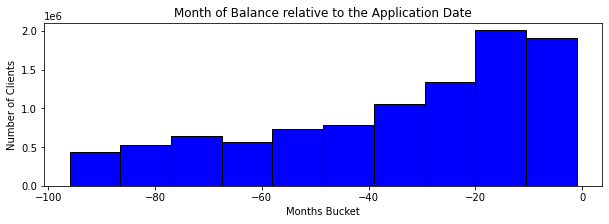

In [111]:
plt.figure(figsize=(10,3))
plt.hist(pos_cash_balance['MONTHS_BALANCE'].values, bins=10, edgecolor='black', color='blue')
plt.title('Month of Balance relative to the Application Date')
plt.xlabel('Months Bucket')
plt.ylabel('Number of Clients')
plt.show()

<h4> 观察发现: </h4>

* 许多客户的Months_Balance在申请日期之前的10到20个月之间。
* 其次是Months_Balance小于10个月的客户。

### 7.2.2 单变量分析 : Cnt_Instalment

Cnt_Installment指的是以前信贷的期限(随时间变化)。

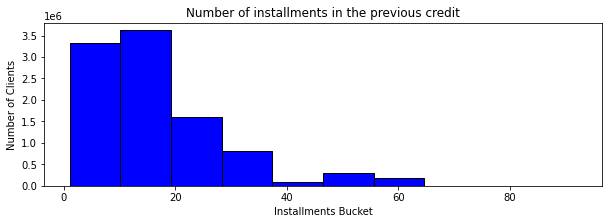

In [112]:
plt.figure(figsize=(10,3))
plt.hist(pos_cash_balance['CNT_INSTALMENT'].values, bins=10, edgecolor='black', color='blue')
plt.title('Number of installments in the previous credit')
plt.xlabel('Installments Bucket')
plt.ylabel('Number of Clients')
plt.show()

<h4>观察发现: </h4>

* 对大多数客户来说，以前的信贷的分期付款次数在10到20之间。
* 其次是分期付款少于10个月的客户。

### 7.2.3 单变量分析: Cnt_Instalment_Future

特征指的是前一笔贷款剩下的分期付款数量。

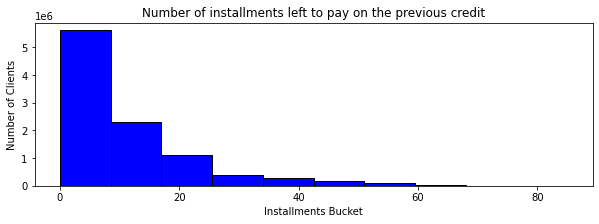

In [113]:
plt.figure(figsize=(10,3))
plt.hist(pos_cash_balance['CNT_INSTALMENT_FUTURE'].values, bins=10, edgecolor='black', color='blue')
plt.title('Number of installments left to pay on the previous credit')
plt.xlabel('Installments Bucket')
plt.ylabel('Number of Clients')
plt.show()

<h4> Observations : </h4>

* 呈现近似反函数分布

### 7.2.4 单变量分析: Name_Contract_Status

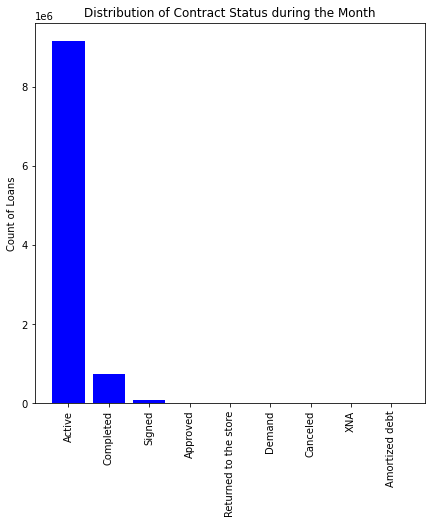

In [114]:
balance_contract_status = Counter()
for status in pos_cash_balance['NAME_CONTRACT_STATUS'].values:
    balance_contract_status.update(status.split(','))

# dict sort by value python: https://stackoverflow.com/a/613218/4084039
contract_status_dict = dict(balance_contract_status)
sorted_contract_status = dict(sorted(balance_contract_status.items(), \
                                        key=lambda kv: kv[1], reverse=True))

ind_12 = np.arange(len(contract_status_dict))
plt.figure(figsize=(7,7))
p1 = plt.bar(ind_12, list(contract_status_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Contract Status during the Month')
plt.xticks(ind_12, list(contract_status_dict.keys()),rotation=90)
plt.show()

<h4> Observations : </h4>

* The Name_Contract_Status在大多数情况下是Active的。

<h2> 7.3 POS Cash Balance Dataset的特征工程 </h2>

<h4> 对多个特征进行特征工程 </h4>

In [115]:
def FE_pos_cash_balance(pos_cash_balance):
    
    pos_balance_data, pos_balance_columns = one_hot_encode(pos_cash_balance)
    
    pos_balance_data['LATE_PAYMENT'] = pos_balance_data['SK_DPD'].apply(lambda x:1 \
                                                if x>0 else 0)
    numerical_agg_pos_balance = {'SK_DPD_DEF': ['max', 'mean','min'],'SK_DPD': ['max', 'mean','min'],
        'MONTHS_BALANCE': ['max', 'mean', 'size'], 'CNT_INSTALMENT': ['max','size'],
        'CNT_INSTALMENT_FUTURE': ['max','size','sum']}

    categorical_agg_pos_balance = {}

    for col in pos_balance_columns:
        categorical_agg_pos_balance[col] = ['mean']

    pos_balance_agg = pos_balance_data.groupby('SK_ID_CURR').agg({**numerical_agg_pos_balance, \
                                                    **categorical_agg_pos_balance})
    col_list_8=[]
    for col in pos_balance_agg.columns.tolist():
        col_list_8.append('POS_'+col[0] + '_' + col[1].upper())

    pos_balance_agg.columns = pd.Index(col_list_8)

    sort_pos_balance = pos_balance_data.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
    pos_group = sort_pos_balance.groupby('SK_ID_PREV')
    
    pos_final_df = pd.DataFrame()
    pos_final_df['SK_ID_CURR'] = pos_group['SK_ID_CURR'].first()
    pos_final_df['MONTHS_BALANCE_MAX'] = pos_group['MONTHS_BALANCE'].max()
    
    pos_final_df['POS_LOAN_COMPLETED_MEAN'] = pos_group['NAME_CONTRACT_STATUS_Completed'].mean()
    pos_final_df['POS_COMPLETED_BEFORE_MEAN'] = pos_group['CNT_INSTALMENT'].first() - \
                                            pos_group['CNT_INSTALMENT'].last()
    pos_final_df['POS_COMPLETED_BEFORE_MEAN'] = pos_final_df.apply(lambda x: 1 if x['POS_COMPLETED_BEFORE_MEAN'] > 0
                                                and x['POS_LOAN_COMPLETED_MEAN'] > 0 else 0, axis=1)
    
    pos_final_df['POS_REMAINING_INSTALMENTS'] = pos_group['CNT_INSTALMENT_FUTURE'].last()
    pos_final_df['POS_REMAINING_INSTALMENTS_RATIO'] = pos_group['CNT_INSTALMENT_FUTURE'].last()/pos_group['CNT_INSTALMENT'].last()
    
    pos_final_df_groupby = pos_final_df.groupby('SK_ID_CURR').sum().reset_index()
    pos_final_df_groupby.drop(['MONTHS_BALANCE_MAX'], axis=1, inplace= True)
    pos_final_agg = pd.merge(pos_balance_agg, pos_final_df_groupby, on= 'SK_ID_CURR',\
                         how= 'left')
    
    del pos_balance_agg, pos_final_df_groupby, pos_group, sort_pos_balance
    gc.collect()
    return pos_final_agg

<h4> 使用'Months_Balance'进行特征工程的函数 </h4>

In [116]:
def FE_pos_cash_balance_months_balance(data, data_temp, pos_cash_balance):
    
    temp_8 = FE_pos_cash_balance(overview.reduce_memory_usage(pos_cash_balance))
    data = data_temp.merge(temp_8, how='left', on='SK_ID_CURR')
    del temp_8
    gc.collect()

    temp_9 = overview.reduce_memory_usage(pos_cash_balance[pos_cash_balance['MONTHS_BALANCE']>=-12].reset_index())
    temp_9.drop(['index'], axis=1, inplace=True)
    temp_9 = FE_pos_cash_balance(temp_9)
    data = data.join(temp_9, how='left', on='SK_ID_CURR',rsuffix='_year')
    del temp_9
    gc.collect()

    temp_10 = overview.reduce_memory_usage(pos_cash_balance[pos_cash_balance['MONTHS_BALANCE']>=-6].reset_index())
    temp_10.drop(['index'], axis=1, inplace=True)
    temp_10 = FE_pos_cash_balance(temp_10)
    data = data.join(temp_10, how='left', on='SK_ID_CURR', rsuffix='_half_year')
    del temp_10
    gc.collect()

    temp_11 = overview.reduce_memory_usage(pos_cash_balance[pos_cash_balance['MONTHS_BALANCE']>=-3].reset_index())
    temp_11.drop(['index'], axis=1, inplace=True)
    temp_11 = FE_pos_cash_balance(temp_11)
    data = data.join(temp_11, how='left', on='SK_ID_CURR', rsuffix='_quarter')
    del temp_11
    gc.collect()

    temp_12 = overview.reduce_memory_usage(pos_cash_balance[pos_cash_balance['MONTHS_BALANCE']>=-1].reset_index())
    temp_12.drop(['index'], axis=1, inplace=True)
    temp_12 = FE_pos_cash_balance(temp_12)
    data = data.join(temp_12, how='left', on='SK_ID_CURR', rsuffix='_month')
    del temp_12
    gc.collect()
    
    return data

<h4> 使用已定义的功能进行特征工程 </h4>

In [117]:
train_data_temp_2 = FE_pos_cash_balance_months_balance(train_data,train_data_temp_2, pos_cash_balance)
train_data_temp_2.shape

Memory usage of dataframe is 238.45 MB
Memory usage after optimization is: 238.45 MB
Decreased by 0.0%
Memory usage of dataframe is 73.51 MB
Memory usage after optimization is: 64.60 MB
Decreased by 12.1%
Memory usage of dataframe is 33.01 MB
Memory usage after optimization is: 29.00 MB
Decreased by 12.1%
Memory usage of dataframe is 14.10 MB
Memory usage after optimization is: 12.39 MB
Decreased by 12.1%
Memory usage of dataframe is 2.99 MB
Memory usage after optimization is: 2.62 MB
Decreased by 12.1%


(307511, 2223)

<h1> 8. Installments Payments Dataset </h1>

<h2>8.1. Installments Payments Data概览 </h2>

In [118]:
installments_payments = overview.reduce_memory_usage(pd.read_csv('F:/data/installments_payments.csv'))
print('Number of data points : ', installments_payments.shape[0])
print('Number of features : ', installments_payments.shape[1])
installments_payments.head()

Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%
Number of data points :  13605401
Number of features :  8


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [119]:
installments_payments.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT'],
      dtype='object')

<h2> 8.2 Installments Payments数据分析 </h2>

### 8.2.1 单变量分析: Num_Instalment_Number

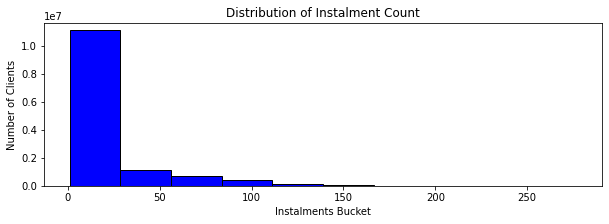

In [120]:
plt.figure(figsize=(10,3))
plt.hist(installments_payments['NUM_INSTALMENT_NUMBER'].values, bins=10, edgecolor='black',\
         color='blue')
plt.title('Distribution of Instalment Count')
plt.xlabel('Instalments Bucket')
plt.ylabel('Number of Clients')
plt.show()

<h4> 观察发现 : </h4>

* 大多数客户在25个月前完成分期付款。

### 8.2.2 单变量分析: Amt_Payment

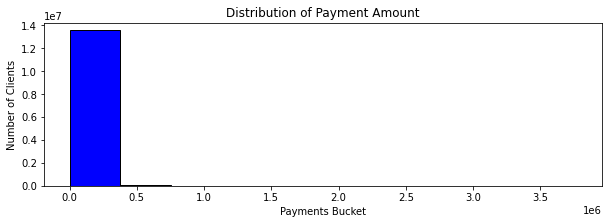

In [121]:
plt.figure(figsize=(10,3))
plt.hist(installments_payments['AMT_PAYMENT'].values, bins=10, edgecolor='black',\
         color='blue')
plt.title('Distribution of Payment Amount')
plt.xlabel('Payments Bucket')
plt.ylabel('Number of Clients')
plt.show()

<h4> 观察发现: </h4>

* 大多数客户在同一分期付款中支付了不到50万卢比的贷款。

<h2> 8.3Installments Payments Data的特征工程</h2>

<h4>对多个特征进行特征工程</h4>

In [122]:
def FE_installments_payments(installments_payments):
    
    pay1 = installments_payments[['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER']+ ['AMT_PAYMENT']]
    pay2 = pay1.groupby(['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'])['AMT_PAYMENT'].sum().reset_index()
    pay_final = pay2.rename(columns={'AMT_PAYMENT': 'AMT_PAYMENT_GROUPED'})
    payments_final = installments_payments.merge(pay_final,\
                            on=['SK_ID_PREV','NUM_INSTALMENT_NUMBER'], how='left')

    payments_final['PAYMENT_DIFFERENCE'] = payments_final['AMT_INSTALMENT'] - \
                                       payments_final['AMT_PAYMENT_GROUPED']
    payments_final['PAYMENT_RATIO'] = payments_final['AMT_INSTALMENT'] / payments_final['AMT_PAYMENT_GROUPED']

    payments_final['PAID_OVER_AMOUNT'] = payments_final['AMT_PAYMENT'] - \
                                     payments_final['AMT_INSTALMENT']
    payments_final['PAID_OVER'] = (payments_final['PAID_OVER_AMOUNT'] > 0).astype(int)
   
    payments_final['DPD'] = payments_final['DAYS_ENTRY_PAYMENT'] - \
                        payments_final['DAYS_INSTALMENT']
    payments_final['DPD'] = payments_final['DPD'].apply(lambda x: 0 if x <= 0 else x)

    payments_final['DBD'] = payments_final['DAYS_INSTALMENT'] - \
                        payments_final['DAYS_ENTRY_PAYMENT']
    payments_final['DBD'] = payments_final['DBD'].apply(lambda x: 0 if x <= 0 else x)
    payments_final['LATE_PAYMENT'] = payments_final['DBD'].apply(lambda x: 1 if x > 0 else 0)
    
    payments_final['INSTALMENT_PAYMENT_RATIO'] = payments_final['AMT_PAYMENT'] / payments_final['AMT_INSTALMENT']
    payments_final['LATE_PAYMENT_RATIO'] = payments_final.apply(lambda x: x['INSTALMENT_PAYMENT_RATIO'] if x['LATE_PAYMENT'] == 1 else 0, axis=1)

    payments_final['SIGNIFICANT_LATE_PAYMENT'] = payments_final['LATE_PAYMENT_RATIO'].apply(lambda x: 1 if x > 0.05 else 0)

    payments_final['DPD_7'] = payments_final['DPD'].apply(lambda x: 1 if x >= 7 else 0)
    payments_final['DPD_15'] = payments_final['DPD'].apply(lambda x: 1 if x >= 15 else 0)
    payments_final['DPD_30'] = payments_final['DPD'].apply(lambda x: 1 if x >= 30 else 0)
    payments_final['DPD_60'] = payments_final['DPD'].apply(lambda x: 1 if x >= 60 else 0)
    payments_final['DPD_90'] = payments_final['DPD'].apply(lambda x: 1 if x >= 90 else 0)
    payments_final['DPD_180'] = payments_final['DPD'].apply(lambda x: 1 if x >= 180 else 0)
    payments_final['DPD_WOF'] = payments_final['DPD'].apply(lambda x: 1 if x >= 720 else 0)
    
    payments_final, pay_final_columns = one_hot_encode(payments_final)

    numeric_agg_payments = {'LATE_PAYMENT': ['max','mean','min'],'AMT_PAYMENT': ['min', 'max',\
                      'mean', 'sum'], 'NUM_INSTALMENT_VERSION': ['nunique'], \
                      'NUM_INSTALMENT_NUMBER':['max'], 'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'PAYMENT_DIFFERENCE': ['max','mean','min','sum'],'DAYS_ENTRY_PAYMENT': ['max', \
        'mean', 'sum'],  'PAID_OVER_AMOUNT': ['max','mean','min']
               }

    for col in pay_final_columns:
        numeric_agg_payments[col] = ['mean']
    
    payments_final_agg = payments_final.groupby('SK_ID_CURR').agg(numeric_agg_payments)
    col_list_9=[]

    for col in payments_final_agg.columns.tolist():
        col_list_9.append('INS_'+col[0]+'_'+col[1].upper())

    payments_final_agg.columns = pd.Index(col_list_9)
    payments_final_agg['INSTALLATION_COUNT'] = payments_final.groupby('SK_ID_CURR').size()
    
    del payments_final
    gc.collect()
    
    return payments_final_agg

<h4> 使用“Days_Instalment”进行特征工程的函数</h4>

In [123]:
def FE_installments_payments_days_instalment(data, data_temp, installments_payments):

    installments_payments['DAYS_ENTRY_PAYMENT'].fillna(0, inplace=True)
    installments_payments['AMT_PAYMENT'].fillna(0.0, inplace=True)

    temp_13 = FE_installments_payments(overview.reduce_memory_usage(installments_payments))
    data = data_temp.join(temp_13, how='left', on='SK_ID_CURR')
    del temp_13
    gc.collect()

    temp_14 = overview.reduce_memory_usage(installments_payments[installments_payments['DAYS_INSTALMENT']>=-365].reset_index())
    temp_14.drop(['index'], axis=1, inplace=True)
    temp_14 = FE_installments_payments(temp_14)
    data = data.join(temp_14, how='left', on='SK_ID_CURR', rsuffix='_year')
    del temp_14
    gc.collect()

    temp_15 = overview.reduce_memory_usage(installments_payments[installments_payments['DAYS_INSTALMENT']>=-182].reset_index())
    temp_15.drop(['index'], axis=1, inplace=True)
    temp_15 = FE_installments_payments(temp_15)
    data = data.join(temp_15, how='left', on='SK_ID_CURR', rsuffix='_half_year')
    del temp_15
    gc.collect()

    temp_16 = overview.reduce_memory_usage(installments_payments[installments_payments['DAYS_INSTALMENT']>=-90].reset_index())
    temp_16.drop(['index'], axis=1, inplace=True)
    temp_16 = FE_installments_payments(temp_16)
    data = data.join(temp_16, how='left', on='SK_ID_CURR', rsuffix='_quarter')
    del temp_16
    gc.collect()

    temp_17 = overview.reduce_memory_usage(installments_payments[installments_payments['DAYS_INSTALMENT']>=-30].reset_index())
    temp_17.drop(['index'], axis=1, inplace=True)
    temp_17 = FE_installments_payments(temp_17)
    data = data.join(temp_17, how='left', on='SK_ID_CURR', rsuffix='_month')
    del temp_17
    gc.collect()
   
    temp_18 = overview.reduce_memory_usage(installments_payments[installments_payments['DAYS_INSTALMENT']>=-14].reset_index())
    temp_18.drop(['index'], axis=1, inplace=True)
    temp_18 = FE_installments_payments(temp_18)
    data = data.join(temp_18, how='left', on='SK_ID_CURR', rsuffix='_fortnight')
    del temp_18
    gc.collect()

    temp_19 = overview.reduce_memory_usage(installments_payments[installments_payments['DAYS_INSTALMENT']>=-7].reset_index())
    temp_19.drop(['index'], axis=1, inplace=True)
    temp_19 = FE_installments_payments(temp_19)
    data = data.join(temp_19, how='left', on='SK_ID_CURR', rsuffix='_week')
    del temp_19
    gc.collect()
    
    return data

<h4> 使用已定义的函数进行特征工程 </h4>

In [124]:
train_data_temp_2 = FE_installments_payments_days_instalment(train_data,train_data_temp_2,installments_payments)
train_data_temp_2.shape

Memory usage of dataframe is 311.40 MB
Memory usage after optimization is: 311.40 MB
Decreased by 0.0%
Memory usage of dataframe is 105.17 MB
Memory usage after optimization is: 92.03 MB
Decreased by 12.5%
Memory usage of dataframe is 51.33 MB
Memory usage after optimization is: 44.91 MB
Decreased by 12.5%
Memory usage of dataframe is 23.63 MB
Memory usage after optimization is: 20.67 MB
Decreased by 12.5%
Memory usage of dataframe is 6.77 MB
Memory usage after optimization is: 5.92 MB
Decreased by 12.5%
Memory usage of dataframe is 2.49 MB
Memory usage after optimization is: 2.17 MB
Decreased by 12.5%
Memory usage of dataframe is 0.96 MB
Memory usage after optimization is: 0.84 MB
Decreased by 12.5%


(307511, 2384)

<h1> 9. Credit Card Balance Dataset </h1>

<h2>9.1.'Credit Card Balance' Dataset概览 </h2>

In [125]:
credit_card_balance = overview.reduce_memory_usage(pd.read_csv('F:/data/credit_card_balance.csv'))
print('Number of data points : ', credit_card_balance.shape[0])
print('Number of features : ', credit_card_balance.shape[1])
credit_card_balance.head()

Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 289.33 MB
Decreased by 57.1%
Number of data points :  3840312
Number of features :  23


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [126]:
credit_card_balance.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

<h2> 9.2 Credit Card Balance EDA </h2>

### 9.2.1 单变量分析 : Months_Balance

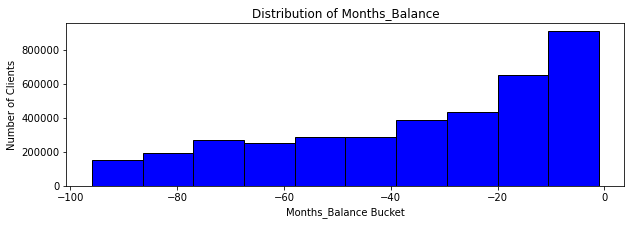

In [127]:
plt.figure(figsize=(10,3))
plt.hist(credit_card_balance['MONTHS_BALANCE'].values, bins=10, edgecolor='black',\
         color='blue')
plt.title('Distribution of Months_Balance')
plt.xlabel('Months_Balance Bucket')
plt.ylabel('Number of Clients')
plt.show()

<h4> Observations : </h4>

* 大多数用户申请前的Months_Balanc在0-10月之间

### 9.2.2 单变量分析 : Cnt_Drawings_Current

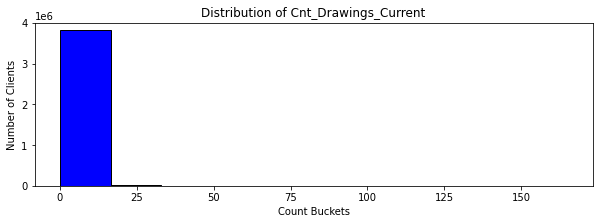

In [128]:
plt.figure(figsize=(10,3))
plt.hist(credit_card_balance['CNT_DRAWINGS_CURRENT'].values, bins=10, edgecolor='black',\
         color='blue')
plt.title('Distribution of Cnt_Drawings_Current')
plt.xlabel('Count Buckets')
plt.ylabel('Number of Clients')
plt.show()

<h4> 观察发现 : </h4>

* 除了极少数例外情况外，绝大多数客户当月的前一笔贷款的提款期都不到25个月。

### 9.2.3 单变量分析: Cnt_Instalment_Mature_Cum

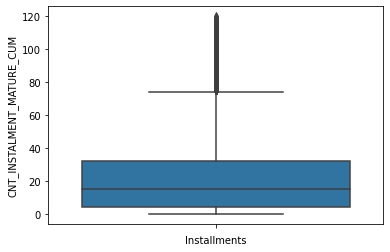

In [129]:
sns.boxplot(y='CNT_INSTALMENT_MATURE_CUM', data=credit_card_balance)
plt.xlabel('Installments')
plt.show()

In [130]:
credit_card_balance['CNT_INSTALMENT_MATURE_CUM'].describe()

count    3535076.0
mean           NaN
std            0.0
min            0.0
25%            4.0
50%           15.0
75%           32.0
max          120.0
Name: CNT_INSTALMENT_MATURE_CUM, dtype: float64

<h4> 观察发现: </h4>

* 正如我们可以从箱线图和详细的“Cnt_Instalment_Mature_Cum”(前一个信用的支付分期数)的特征描述中看到的那样，最小值为0，而最大值为120。
* 75%都小于32。

<h2> 9.3 Credit Card Balance Data特征工程 </h2>

<h4> 对多个特征进行特征工程 </h4>

In [131]:
def FE_credit_card_balance(credit_card_balance):
    
    cc_balance_data, cc_balance_columns = one_hot_encode(credit_card_balance)
    cc_balance_data.rename(columns={'AMT_RECIVABLE': 'AMT_RECEIVABLE'}, inplace=True)

    cc_balance_data['LIMIT_USE'] = cc_balance_data['AMT_BALANCE'] / cc_balance_data['AMT_CREDIT_LIMIT_ACTUAL']
    cc_balance_data['PAYMENT_DIV_MIN'] = cc_balance_data['AMT_PAYMENT_CURRENT'] / cc_balance_data['AMT_INST_MIN_REGULARITY']
    cc_balance_data['LATE_PAYMENT'] = cc_balance_data['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    
    cc_balance_data['DRAWING_LIMIT_RATIO'] = cc_balance_data['AMT_DRAWINGS_ATM_CURRENT'] / cc_balance_data['AMT_CREDIT_LIMIT_ACTUAL']

    cc_balance_data.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_balance_data_agg = cc_balance_data.groupby('SK_ID_CURR').agg(['max', 'mean', 'sum', 'var'])
    
    col_list_9=[]

    for col in cc_balance_data_agg.columns.tolist():
        col_list_9.append('CR_'+col[0]+'_'+col[1].upper())
    
    cc_balance_data_agg.columns = pd.Index(col_list_9)

    cc_balance_data_agg['CREDIT_COUNT'] = cc_balance_data.groupby('SK_ID_CURR').size()
    
    del cc_balance_data, cc_balance_columns
    gc.collect()
    
    return cc_balance_data_agg

<h4> 使用'Months_Balance'进行特征工程的函数 </h4>

In [132]:
def FE_credit_card_balance_months_balance(data,data_temp,credit_card_balance):
    
    temp_20 = FE_credit_card_balance(overview.reduce_memory_usage(credit_card_balance))
    data = data_temp.join(temp_20, how='left', on='SK_ID_CURR')
    del temp_20
    gc.collect()
    
    temp_21 = overview.reduce_memory_usage(credit_card_balance[credit_card_balance['MONTHS_BALANCE']>=-12].reset_index())
    temp_21.drop(['index'], axis=1, inplace=True)
    temp_21 = FE_credit_card_balance(temp_21)
    data = data.join(temp_21, how='left', on='SK_ID_CURR', rsuffix='_year')
    del temp_21
    gc.collect()

    temp_22 = overview.reduce_memory_usage(credit_card_balance[credit_card_balance['MONTHS_BALANCE']>=-6].reset_index())
    temp_22.drop(['index'], axis=1, inplace=True)
    temp_22 = FE_credit_card_balance(temp_22)
    data = data.join(temp_22, how='left', on='SK_ID_CURR', rsuffix='_half_year')
    del temp_22
    gc.collect()

    temp_23 = overview.reduce_memory_usage(credit_card_balance[credit_card_balance['MONTHS_BALANCE']>=-3].reset_index())
    temp_23.drop(['index'], axis=1, inplace=True)
    temp_23 = FE_credit_card_balance(temp_23)
    data = data.join(temp_23, how='left', on='SK_ID_CURR', rsuffix='_quarter')
    del temp_23
    gc.collect()

    temp_24 = overview.reduce_memory_usage(credit_card_balance[credit_card_balance['MONTHS_BALANCE']>=-1].reset_index())
    temp_24.drop(['index'], axis=1, inplace=True)
    temp_24 = FE_credit_card_balance(temp_24)
    data = data.join(temp_24, how='left', on='SK_ID_CURR', rsuffix='_month')
    del temp_24
    gc.collect()
    
    return data

<h4> 使用已定义的函数进行特征工程</h4>

In [133]:
train_data_temp_2 = FE_credit_card_balance_months_balance(train_data,train_data_temp_2,credit_card_balance)
train_data_temp_2.shape

Memory usage of dataframe is 289.33 MB
Memory usage after optimization is: 289.33 MB
Decreased by 0.0%
Memory usage of dataframe is 88.60 MB
Memory usage after optimization is: 84.53 MB
Decreased by 4.6%
Memory usage of dataframe is 46.35 MB
Memory usage after optimization is: 44.22 MB
Decreased by 4.6%
Memory usage of dataframe is 21.35 MB
Memory usage after optimization is: 20.37 MB
Decreased by 4.6%
Memory usage of dataframe is 5.17 MB
Memory usage after optimization is: 4.94 MB
Decreased by 4.6%


(307511, 2981)

<h3> 删除重复的特性</h3>

In [134]:
#Removing any duplicate features, if any are present in the final dataset
train_data = train_data_temp_2.loc[:,~train_data_temp_2.columns.duplicated()]
train_data.shape

(307511, 2981)

<h1> 10. Test Data的特征化 </h1>

In [135]:
from datetime import datetime

In [136]:
start = datetime.now()

test_data = fix_nulls_outliers(test_data)

test_data_temp_1 = FE_application_data(test_data)
bureau_data_balance_final = FE_bureau_data_2(bureau_data, bureau_balance,bureau_data_columns,\
                                             bureau_balance_columns)
test_data_temp_2 = test_data_temp_1.join(bureau_data_balance_final, how='left', on='SK_ID_CURR')

print("="*100)
test_data_temp_2 = FE_previous_application_days_decision(test_data, test_data_temp_2,previous_application)
print("="*100)
print(" "*100)

print("="*100)
test_data_temp_2 = FE_pos_cash_balance_months_balance(test_data,test_data_temp_2, pos_cash_balance)
print("="*100)
print(" "*100)

print("="*100)
test_data_temp_2 = FE_installments_payments_days_instalment(test_data,test_data_temp_2,installments_payments)
print("="*100)
print(" "*100)

print("="*100)
test_data_temp_2 = FE_credit_card_balance_months_balance(test_data,test_data_temp_2,credit_card_balance)
print("="*100)
print(" "*100)

#Removing any duplicate features, if any are present in the final dataset
test_data = test_data_temp_2.loc[:,~test_data_temp_2.columns.duplicated()]

print(" "*100)
print("Time taken to run this cell :", datetime.now() - start)

Memory usage of dataframe is 293.08 MB
Memory usage after optimization is: 293.08 MB
Decreased by 0.0%
Memory usage of dataframe is 105.06 MB
Memory usage after optimization is: 102.87 MB
Decreased by 2.1%
Memory usage of dataframe is 40.52 MB
Memory usage after optimization is: 39.67 MB
Decreased by 2.1%
Memory usage of dataframe is 16.19 MB
Memory usage after optimization is: 15.77 MB
Decreased by 2.6%
Memory usage of dataframe is 6.82 MB
Memory usage after optimization is: 6.65 MB
Decreased by 2.6%
Memory usage of dataframe is 3.22 MB
Memory usage after optimization is: 3.13 MB
Decreased by 2.6%
Memory usage of dataframe is 1.57 MB
Memory usage after optimization is: 1.53 MB
Decreased by 2.6%
                                                                                                    
Memory usage of dataframe is 238.45 MB
Memory usage after optimization is: 238.45 MB
Decreased by 0.0%
Memory usage of dataframe is 73.51 MB
Memory usage after optimization is: 64.60 MB
Decrease

<h1> 10. 在构建机器学习模型之前 </h1>

<h2>10.1. 训练测试数据分割 </h2>

* 在我们构建真实的机器学习模型之前，我们尝试进行训练-测试分割。我们在每个数据集中获得的数据点数量如下所示。

In [137]:
print('Shape of the Train Data: {}'.format(train_data.shape))
print('Shape of the Test Data: {}'.format(test_data.shape))

Shape of the Train Data: (307511, 2981)
Shape of the Test Data: (48744, 2979)


In [138]:
sample_train_data = train_data.sample(n=50000, random_state=42)
X_data_train = sample_train_data.drop(['TARGET'], axis=1) 
#For the X_data_train we select all the columns except the TARGET column that has the class labels

Y_data_train = sample_train_data['TARGET'].fillna(0)
#For the Y_data_train, we select only the TARGET column

In [139]:
from sklearn.model_selection import train_test_split

In [140]:
X_train_final, X_cv_final, Y_train_final, Y_cv_final = train_test_split(X_data_train, Y_data_train, test_size=0.20,stratify=Y_data_train)
print(X_train_final.shape, Y_train_final.shape)
print(X_cv_final.shape, Y_cv_final.shape)

(40000, 2980) (40000,)
(10000, 2980) (10000,)


<h2>10.2. Pickling Dataframes obtained for Future Use </h2>

In [142]:
#Pickling the Dataframes obtained for future use:-

import pandas as pd
import pickle
import os

if not os.path.isfile('F:/pickles/train_data.pkl'):
    train_data.to_pickle('F:/pickles/train_data.pkl')
train_data = pd.read_pickle('F:/pickles/train_data.pkl')

if not os.path.isfile('F:/pickles/test_data'):
    test_data.to_pickle('F:/pickles/test_data')
test_data = pd.read_pickle('F:/pickles/test_data')

if not os.path.isfile('F:/pickles/X_train_final_hcdr_new'):
    X_train_final.to_pickle('F:/pickles/X_train_final_hcdr_new')
X_train_final_hcdr_new = pd.read_pickle('F:/pickles/X_train_final_hcdr_new')

if not os.path.isfile('F:/pickles/Y_train_final_hcdr_new'):
    Y_train_final.to_pickle('F:/pickles/Y_train_final_hcdr_new')
Y_train_final_hcdr_new = pd.read_pickle('F:/pickles/Y_train_final_hcdr_new')

if not os.path.isfile('F:/pickles/X_cv_final_hcdr_new'):
    X_cv_final.to_pickle('F:/pickles/X_cv_final_hcdr_new')
X_cv_final_hcdr_new = pd.read_pickle('F:/pickles/X_cv_final_hcdr_new')

if not os.path.isfile('F:/pickles/Y_cv_final_hcdr_new'):
    Y_cv_final.to_pickle('F:/pickles/Y_cv_final_hcdr_new')
Y_cv_final_hcdr_new = pd.read_pickle('F:/pickles/Y_cv_final_hcdr_new')

if not os.path.isfile('F:/pickles/X_data_train'):
    X_data_train.to_pickle('F:/pickles/X_data_train')
X_data_train = pd.read_pickle('F:/pickles/X_data_train')

if not os.path.isfile('F:/pickles/Y_data_train'):
    Y_data_train.to_pickle('F:/pickles/Y_data_train')
Y_data_train = pd.read_pickle('F:/pickles/Y_data_train')

<h2>10.3. Obtaining Dataframe from only Top 500 Most Important Features </h2>

In [145]:
from sklearn.feature_selection import SelectKBest, f_classif
X_train_final_arr = np.nan_to_num(X_train_final_hcdr_new)
X_cv_final_arr = np.nan_to_num(X_cv_final_hcdr_new)

S = SelectKBest(f_classif, k=500)

X_train_k_best = S.fit_transform(X_train_final_arr, Y_train_final_hcdr_new)
X_cv_k_best = S.transform(X_cv_final_arr)

# Get columns to keep and create new dataframe with those only
cols = S.get_support(indices=True)

features_top_df_train = X_train_final_hcdr_new.iloc[:,cols]
features_top_df_cv = X_cv_final_hcdr_new.iloc[:,cols]

In [146]:
if not os.path.isfile('pickles/features_top_df_train.pkl'):
    features_top_df_train.to_pickle('pickles/features_top_df_train.pkl')
features_top_df_train = pd.read_pickle('pickles/features_top_df_train.pkl')

<h2>10.4. Distribution of y_i's in Train and Cross Validation datasets </h2>

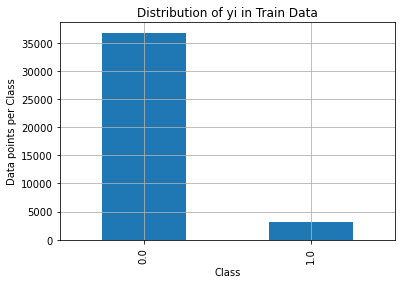

Number of data points in class 0 : 36782 ( 91.955 %)
Number of data points in class 1 : 3218 ( 8.045 %)
--------------------------------------------------------------------------------


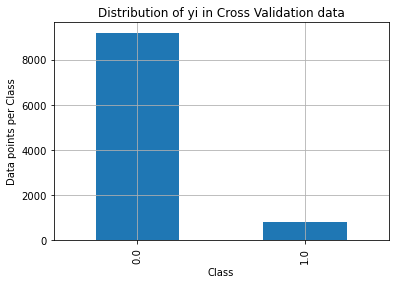

Number of data points in class 0 : 9195 ( 91.95 %)
Number of data points in class 1 : 805 ( 8.05 %)


In [147]:
# it returns a dict, keys as class labels and values as the number of data points in that class
Y_train_final_hcdr_new = Y_train_final_hcdr_new.to_frame()
Y_cv_final_hcdr_new = Y_cv_final_hcdr_new.to_frame()

train_class_distribution = Y_train_final_hcdr_new['TARGET'].value_counts().sort_index()
cv_class_distribution = Y_cv_final_hcdr_new['TARGET'].value_counts().sort_index()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in Train Data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i, ':',train_class_distribution.values[i], \
        '(', np.round((train_class_distribution.values[i]/Y_train_final_hcdr_new.shape[0]*100), 3), '%)')
print('-'*80)

my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in Cross Validation data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i, ':',cv_class_distribution.values[i], \
          '(', np.round((cv_class_distribution.values[i]/Y_cv_final_hcdr_new.shape[0]*100), 3), '%)')


<h2>10.5. Standardizing the Final Dataset Obtained </h2>

In [148]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

features_top_df_test = test_data[features_top_df_train.columns]
features_top_df_test_final = np.nan_to_num(features_top_df_test)
features_top_df_cv_final = np.nan_to_num(features_top_df_cv)

scaler.fit(features_top_df_train)
scaler_train = scaler.transform(features_top_df_train)
scaler_cv = scaler.transform(features_top_df_cv_final)
scaler_test = scaler.transform(features_top_df_test_final)

Y_train_final_hcdr_new = np.nan_to_num(Y_train_final_hcdr_new)
Y_cv_final_hcdr_new = np.nan_to_num(Y_cv_final_hcdr_new)

scaler_train = np.nan_to_num(scaler_train)
scaler_cv = np.nan_to_num(scaler_cv)
scaler_test = np.nan_to_num(scaler_test)

<h2>10.6. Additional Functions </h2>

<h4> Function to obtain predictions by Batches </h4>

In [156]:
def batch_predict(clf, data):
   
    y_data_pred = []
    loop_count = data.shape[0] - data.shape[0]%1000
   
    for i in range(0, loop_count, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])

    # y_data_pred.extend(clf.predict_proba(data[loop_count:])[:,1])
    
    return y_data_pred

<h4> Function to obtain Ideal value of Threshold </h4>

In [150]:
def obtain_threshold(thresholds,tpr,fpr):   
    
    obtain_threshold.best_tradeoff = tpr*(1-fpr)
    ideal_threshold = thresholds[obtain_threshold.best_tradeoff.argmax()]
 
    return ideal_threshold

<h4> Function to obtain the Confusion, Precision & Recall Matrices </h4>

In [151]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_y, predict_y):
    
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
   
    B =(C/C.sum(axis=0))
   
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
   
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.set(font_scale=1.1)
    sns.set_style(style='white')
    
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".10f", xticklabels=labels, \
                yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B,annot=True, cmap=cmap, fmt=".10f", xticklabels=labels, \
                yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".10f", xticklabels=labels, \
                yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h1>11. Machine Learning Models</h1>

<h2>11.1. Logistic Regression </h2>

<h3> 11.1.1 Hyperparameter Tuning on the CV Data </h3>

For values of alpha =  1e-05 the roc_auc score is: 0.512696678926908
For values of alpha =  0.0001 the roc_auc score is: 0.54960655770926
For values of alpha =  0.001 the roc_auc score is: 0.5898963452321847
For values of alpha =  0.01 the roc_auc score is: 0.6781588697611111
For values of alpha =  0.1 the roc_auc score is: 0.7361608219427922
For values of alpha =  1 the roc_auc score is: 0.7247941258920761
For values of alpha =  10 the roc_auc score is: 0.7022127202537161


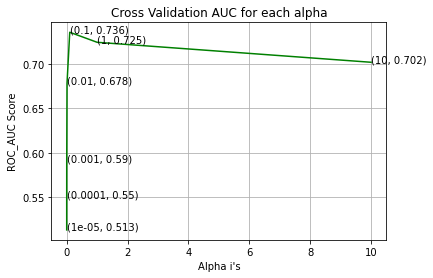

For values of best alpha =  0.1 The train roc_auc is: 0.7503304538770569
For values of best alpha =  0.1 The cv roc_auc is: 0.7236255188648976
                                                                                                    
Time taken to run this cell : 0:01:18.046247


In [157]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score

alpha = [10 ** x for x in range(-5, 2)] # hyperparameter for SGD classifier.

train_auc=[]
cv_auc=[]

roc_auc_array=[]

start = datetime.now()

roc_auc_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42,\
                        class_weight='balanced')
    clf.fit(scaler_train, Y_train_final_hcdr_new)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(scaler_train, Y_train_final_hcdr_new)
    
    Y_train_pred = batch_predict(clf=sig_clf, data=scaler_train)
    Y_cv_pred = batch_predict(sig_clf, scaler_cv)
    
    train_auc.append(roc_auc_score(Y_train_final_hcdr_new,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv_final_hcdr_new,Y_cv_pred))

    roc_auc_array.append(roc_auc_score(Y_cv_final_hcdr_new, Y_cv_pred))
    print('For values of alpha = ', i, "the roc_auc score is:", roc_auc_score(Y_cv_final_hcdr_new,Y_cv_pred))

fig, ax = plt.subplots()
ax.plot(alpha, roc_auc_array,c='g')
for i, txt in enumerate(np.round(roc_auc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],roc_auc_array[i]))
plt.grid()
plt.title("Cross Validation AUC for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("ROC_AUC Score")
plt.show()

best_alpha = np.argmax(roc_auc_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)

clf.fit(scaler_train,  Y_train_final_hcdr_new)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(scaler_train, Y_train_final_hcdr_new)

predict_y_train = batch_predict(sig_clf,scaler_train)
print('For values of best alpha = ', alpha[best_alpha], "The train roc_auc is:",\
                                  roc_auc_score(Y_train_final_hcdr_new, predict_y_train))

predict_y_cv = batch_predict(sig_clf,scaler_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cv roc_auc is:",\
                                  roc_auc_score(Y_cv_final_hcdr_new, predict_y_cv))

print(" "*100)
print("Time taken to run this cell :", datetime.now() - start)

<h4> Observations :- </h4>

* In the roc_auc values that we obtained, since the values are quite close to each other for Train and CV, we can say with assurance that our model is not overfitting).
* We could have said that the model was underfitting if the Train and CV roc_auc values were approximately same as each other and had we trained a more complex model such as GBDT and this complex model gave an roc_auc score higher than 0.7202. (Since Logistic Regression is a very simple linear classifier it has a much higher chance of underfitting).

<h3> 11.1.2 Obtaining ROC Curves on Train and CV Datasets </h3>

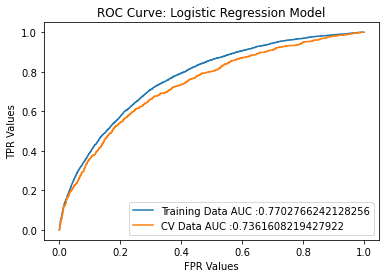

Ideal Threshold for the CV Dataset = 0.14070865163272178
Time taken to run this cell : 0:00:03.855468


In [164]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from scipy import integrate

start = datetime.now()

clf = SGDClassifier(alpha=0.1, penalty='l2', loss='log', random_state=42,class_weight='balanced')
clf.fit(scaler_train, Y_train_final_hcdr_new)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(scaler_train, Y_train_final_hcdr_new)

train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(Y_train_final_hcdr_new,sig_clf.predict_proba(scaler_train)[:,1])
cv_fpr1,cv_tpr1, cv_thresholds1 = roc_curve(Y_cv_final_hcdr_new, sig_clf.predict_proba(scaler_cv)[:,1])

plt.plot(train_fpr1,train_tpr1, label ="Training Data AUC :" + str(auc(train_fpr1,train_tpr1)))
plt.plot(cv_fpr1,cv_tpr1,label="CV Data AUC :" + str(auc(cv_fpr1,cv_tpr1)))
plt.legend()

plt.xlabel("FPR Values")
plt.ylabel("TPR Values")
plt.title('ROC Curve: Logistic Regression Model')

plt.grid(False)
plt.show()

print('Ideal Threshold for the CV Dataset =', obtain_threshold(cv_thresholds1,cv_tpr1,cv_fpr1))
print("Time taken to run this cell :", datetime.now() - start)

<h3> 11.1.3 Plotting Confusion, Precision & Recall Matrices on CV Data </h3>

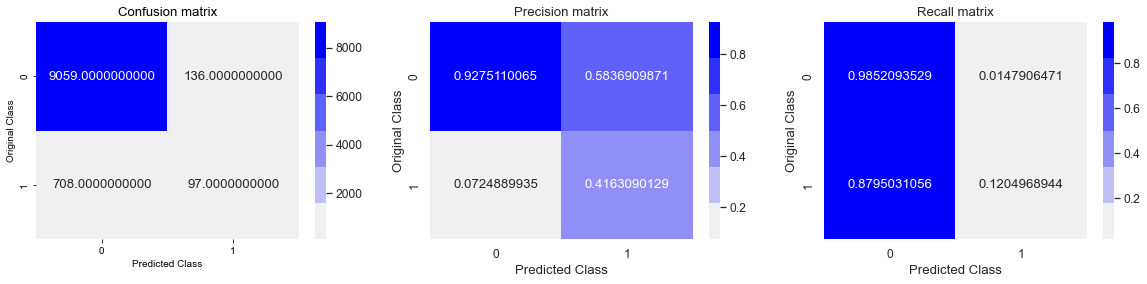

In [165]:
Y_cv_final_plot = Y_cv_final_hcdr_new.flatten()
Y_cv_final_pred = sig_clf.predict(scaler_cv)

plot_confusion_matrix(Y_cv_final_plot, Y_cv_final_pred)

<h4> Observations :- </h4>

* Here, according to the Confusion Matrix we can see that the Accuracy in this case :- (54319 + 852)/61503 ie 89.70%.
* Precision Matrix :- In your Precision matrix the column sum = 1. It is saying that of all the points that are predicted to belong to class 0, 92.96% of them actually belong to class 0 and 7.03% of them belong to class 1. Similarly of all the points that are predicted to belong to class 1, 27.74% of the points belong to class 1 and 72.25% of the points actually belong to class 0.
* Recall Matrix :- In your recall matrix, the row sum = 1. Hence, here it says that for all the points that belong to class 0 our model predicted 96.07% of them belonging to class 0 and 3.9% of them belonging to class 1. Similarly of all the points that originally belong to class 1, 17.16% of those points have been predicted by the model to belong to class 1 and 82.83% to belong to class 0. {This class 1 Value of Recall is the major cause of concern in this case}. The diagonal values that you see in the Recall Matrix are the Recall Values for Class 0 and the Recall values for class 1.

<h3> 11.1.4 Evaluating on the Test Dataset </h3>

In [166]:
from sklearn.linear_model import LogisticRegression

for col in features_top_df_test.columns:
    if col=='TARGET':
        features_top_df_test = features_top_df_test.drop(['TARGET'],axis=1)
    if col =='SK_ID_CURR':
        features_top_df_test = features_top_df_test.drop(['SK_ID_CURR'],axis=1)

logistic_regression = LogisticRegression(C=0.1, class_weight='balanced',random_state=42,penalty='l2')
logistic_regression.fit(scaler_train, Y_train_final_hcdr_new)

scaler_test = np.nan_to_num(scaler_test)
lr_test_predict = logistic_regression.predict_proba(scaler_test)[:,1]

In [167]:
features_top_df_test['SK_ID_CURR'] = test_data['SK_ID_CURR']
features_top_df_test['TARGET'] = lr_test_predict
features_top_df_test['SK_ID_CURR'] = features_top_df_test['SK_ID_CURR'].apply(lambda x: np.int32(x))
features_top_df_test[['SK_ID_CURR', 'TARGET']].to_csv('hcdr_logistic_regression_500f.csv', index= False)

<img src="Home_Credit/hcdr_logistic_regression_500f.png"/>

<h4> Observations :- </h4>

* We can see from above that the AUC Value obtained on the Test Data using the Logistic Regression Model in the Kaggle Competition = 0.71840.

<h2>11.2. Linear SVM </h2>

<h3> 11.2.1 Hyperparameter Tuning on the CV Data </h3>

For values of alpha =  1e-05 the roc_auc score is: 0.5292626630054816
For values of alpha =  0.0001 the roc_auc score is: 0.5556229249625944
For values of alpha =  0.001 the roc_auc score is: 0.5689669311231124
For values of alpha =  0.01 the roc_auc score is: 0.6656336991140878
For values of alpha =  0.1 the roc_auc score is: 0.7234034159801945
For values of alpha =  1 the roc_auc score is: 0.7299854430743147
For values of alpha =  10 the roc_auc score is: 0.6978865775688246


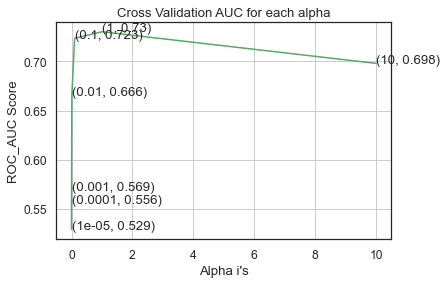

For values of best alpha =  1 The train roc_auc is: 0.7315110405253684
For values of best alpha =  1 The cv roc_auc is: 0.7149205448545828
                                                                                                    
Time taken to run this cell : 0:01:09.741319


In [168]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

train_auc=[]
cv_auc=[]

roc_auc_array=[]

start = datetime.now()

roc_auc_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42,\
                        class_weight='balanced')
    clf.fit(scaler_train, Y_train_final_hcdr_new)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(scaler_train, Y_train_final_hcdr_new)
    
    Y_train_pred = batch_predict(sig_clf, scaler_train)
    Y_cv_pred = batch_predict(sig_clf, scaler_cv)
    
    train_auc.append(roc_auc_score(Y_train_final_hcdr_new,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv_final_hcdr_new,Y_cv_pred))

    roc_auc_array.append(roc_auc_score(Y_cv_final_hcdr_new, Y_cv_pred))
    print('For values of alpha = ', i, "the roc_auc score is:", roc_auc_score(Y_cv_final_hcdr_new,Y_cv_pred))

fig, ax = plt.subplots()
ax.plot(alpha, roc_auc_array,c='g')
for i, txt in enumerate(np.round(roc_auc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],roc_auc_array[i]))
plt.grid()
plt.title("Cross Validation AUC for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("ROC_AUC Score")
plt.show()

best_alpha = np.argmax(roc_auc_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)

clf.fit(scaler_train,  Y_train_final_hcdr_new)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(scaler_train, Y_train_final_hcdr_new)

predict_y_train = batch_predict(sig_clf,scaler_train)
print('For values of best alpha = ', alpha[best_alpha], "The train roc_auc is:",\
                                  roc_auc_score(Y_train_final_hcdr_new, predict_y_train))

predict_y_cv = batch_predict(sig_clf,scaler_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cv roc_auc is:",\
                                  roc_auc_score(Y_cv_final_hcdr_new, predict_y_cv))

print(" "*100)
print("Time taken to run this cell :", datetime.now() - start)